In [1]:
import matplotlib
%matplotlib inline
from pylab import *
import caesar
import h5py, os, sys
import yt, pickle
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic as bst
from scipy.stats import binned_statistic_2d as bst2
from scipy.signal import savgol_filter as sgf

matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

safecolor={
    'silver':"#c0c0c0",
    'gray':"#808080",
    'black':"#000000",
    'red':"#ff0000",
    'maroon':"#800000",
    'yellow':"#ffff00",
    'olive':"#707030",
    'lime':"#00ee00",
    'green':"#009000",
    'aqua':"#00eeee",
    'teal':"#00a0a0",
    'blue':"#0000ff",
    'nave':"#000080",
    'fuchsia':"#ff00ff",
    'purple':"#900090"
}

/usr/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


# GIZMO run -- select and match center clusters

In [2]:
ahf_data=np.load('../Halo_mass_function_mass-difference/GIZMO/GS_Mass_snap_128info.npy')
#ReginIDs HIDs  HosthaloID Mvir[3] Xc Yc Zc[4-6]  Rvir[7] fMhires[8] cNFW[9] Mgas200[10] M*200[11] M500[12] R500[13] fgas500[14] f*500[15]

In [3]:
# Now get the cental clusters -- AHF
if os.path.isfile("GIZMO-Mass_snap_128-center-cluster.txt"):
    cc_data=np.loadtxt("GIZMO-Mass_snap_128-center-cluster.txt")
else:
    cc=np.array([500000,500000,500000])
    cc_data=np.zeros((324,16))
    for i in np.arange(1,325):
        idr=ahf_data[:,0]==i
        dist=np.sqrt(np.sum((ahf_data[idr,4:7]-cc)**2, axis=1))
        idcc=np.where((dist<2100)&(ahf_data[idr,3]>4.5e14)&(ahf_data[idr,2]<1))[0]
        if len(idcc) == 1:
            cc_data[i-1,:]=ahf_data[idr][idcc][0]
        elif len(idcc) > 1:  #We use the Massive one  only region 38
            idmm=np.argmax(ahf_data[idr,3][idcc])
            cc_data[i-1,:]=ahf_data[idr][idcc][idmm]
        else:
            print(i,idcc)
    np.savetxt('GIZMO-Mass_snap_128-center-cluster.txt',cc_data,
               header="ReginIDs HIDs  HosthaloID Mvir[3] Xc Yc Zc[4-6]  Rvir[7] fMhires[8] cNFW[9] "+
               " Mgas200[10] M*200[11] M500[12] R500[13] fgas500[14] f*500[15]")

In [20]:
ds.galaxies[0].info()

{'GroupID': 0,
 'ages': {'mass_weighted': unyt_quantity(11.92709541, 'Gyr'),
          'metal_weighted': unyt_quantity(1.97905718e+13, 'Gyr')},
 'bh_fedd': unyt_quantity(0.00544, 'dimensionless'),
 'bhlist_end': 11,
 'bhlist_start': 0,
 'bhmdot': unyt_quantity(4.69074106, 'Msun/yr'),
 'central': True,
 'cloud_index_list_end': 0,
 'cloud_index_list_start': 0,
 'contamination': 0.0,
 'glist_end': 7,
 'glist_start': 0,
 'local_mass_density': {'1000': unyt_quantity(1102.53859935, 'Msun/kpccm**3'),
                        '300': unyt_quantity(24977.11179148, 'Msun/kpccm**3'),
                        '3000': unyt_quantity(73.45261972, 'Msun/kpccm**3')},
 'local_number_density': {'1000': unyt_quantity(1.52788745e-08, 'kpccm**(-3)'),
                          '300': unyt_quantity(1.23787178e-07, 'kpccm**(-3)'),
                          '3000': unyt_quantity(1.37934284e-09, 'kpccm**(-3)')},
 'masses': {'H2': unyt_quantity(5.17699715e+09, 'Msun'),
            'H2_30kpc': unyt_quantity(0., 'Msun

In [3]:
# use distance between FoF halo and AHF halo centers, but check the central galaxy mass not always at the ahf halo center!!!
# use distance between galaxy and AHF halo center, but mark their parent FoF halo ID
path='/home2/weiguang/data6/CL300_Caesar/'
Mac=np.copy(cc_data[:,:7])# region ID, AHF ID, Caesar Hid and Gid, 2 distances!
for i in np.arange(1,325):
    crg='NewMDCLUSTER_%04d' % i

    ds=caesar.load(path+crg+'/Caesar_snap_128.hdf5')
    hpos=np.array([j.minpotpos for j in ds.halos])
    hids=np.array([j.GroupID for j in ds.halos])
#     hcgids=np.array([j.central_galaxy.GroupID if j.central_galaxy is not None else -1 for j in ds.halos ])
    gpos=np.array([j.minpotpos for j in ds.galaxies])  #CoM
    gmas=np.array([j.masses['stellar'] for j in ds.galaxies])  #CoM
    gids=np.array([j.GroupID for j in ds.galaxies])
    dist=np.linalg.norm(gpos-cc_data[i-1,4:7]/0.6777,axis=1)
    if (gmas[dist.argmin()] < 5.2e11):
        print(i, cc_data[i-1,4:7],gpos[dist.argmin()]*0.6777, np.log10(gmas[dist.argmin()]))
        # we will try the other way round using galaxies
#         gdist=np.linalg.norm(gpos-cc_data[i-1,4:7]/0.6777,axis=1)
#         if gmas[gdist.argmin()] < 3.5e11:
#             raise ValueError(gdist.min(),gmas[gdist.argmin()])
#         else:
#             Mac[i-1,2],Mac[i-1,3]=ds.galaxies[gdist.argmin()].parent_halo_index,gids[gdist.argmin()]
#             Mac[i-1,4],Mac[i-1,5]=np.sqrt(np.sum((hpos[hids==ds.galaxies[gdist.argmin()].parent_halo_index]-cc_data[i-1,4:7]/0.6777)**2)),gdist.min()
        # search for near largest galaxy
        idinr=dist<300
        print(np.log10(gmas[idinr].max()))
        maxmid=gmas[idinr].argmax()
        phi=ds.galaxies[np.where(gids==gids[idinr][maxmid])[0][0]].parent_halo_index
        Mac[i-1,2],Mac[i-1,3]=phi,gids[idinr][maxmid]
        Mac[i-1,4],Mac[i-1,5]=np.sqrt(np.sum((hpos[hids==phi] - cc_data[i-1,4:7]/0.6777)**2)),dist[idinr][maxmid]
        Mac[i-1,6] = np.log10(gmas[idinr][maxmid])
    else:
        phi=ds.galaxies[dist.argmin()].parent_halo_index
        Mac[i-1,2],Mac[i-1,3]=phi,gids[dist.argmin()]
        Mac[i-1,4],Mac[i-1,5]=np.sqrt(np.sum((hpos[hids==phi]-cc_data[i-1,4:7]/0.6777)**2)), dist.min()
        Mac[i-1,6] = np.log10(gmas[dist.argmin()])

np.savetxt('GIZMO-Matched-AHFhalo-Caesar-galaxy.txt',Mac,header="# region ID, AHF ID, Caesar Hid, Gid, dist hpos, gpos, select Mgal")

yt : [INFO     ] 2021-08-24 11:54:28,546 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0001/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:54:29,014 Found 2653 halos
yt : [INFO     ] 2021-08-24 11:54:29,284 Found 1786 galaxies
yt : [INFO     ] 2021-08-24 11:54:29,457 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0002/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:54:29,871 Found 2311 halos
yt : [INFO     ] 2021-08-24 11:54:30,150 Found 1557 galaxies
yt : [INFO     ] 2021-08-24 11:54:30,388 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0003/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:54:30,804 Found 2881 halos
yt : [INFO     ] 2021-08-24 11:54:31,023 Found 2346 galaxies
yt : [INFO     ] 2021-08-24 11:54:31,248 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0004/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:54:31,735 Found 2796 halos
yt : [INFO     ] 2021-08-24 11:54:32,011 Found 1992 galaxies
yt : [INFO     ] 2021-08-24 11:5

32 [500292.95879406 500495.49537701 500359.42452294] [500284.11223125 500491.91199375 500375.898225  ] 10.460613311149395
12.119846344989996


yt : [INFO     ] 2021-08-24 11:54:58,222 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0033/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:54:58,566 Found 2078 halos
yt : [INFO     ] 2021-08-24 11:54:58,917 Found 1222 galaxies
yt : [INFO     ] 2021-08-24 11:54:59,048 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0034/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:54:59,474 Found 1921 halos
yt : [INFO     ] 2021-08-24 11:54:59,781 Found 1080 galaxies
yt : [INFO     ] 2021-08-24 11:54:59,895 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0035/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:55:00,269 Found 2051 halos
yt : [INFO     ] 2021-08-24 11:55:00,545 Found 1313 galaxies
yt : [INFO     ] 2021-08-24 11:55:00,664 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0036/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:55:01,007 Found 1965 halos
yt : [INFO     ] 2021-08-24 11:55:01,320 Found 1211 galaxies
yt : [INFO     ] 2021-08-24 11:5

39 [500609.13415804 500438.70488258 500552.12925558] [500576.53978125 500443.329375   500544.7302375 ] 9.81847023365654
12.464427234128173


yt : [INFO     ] 2021-08-24 11:55:04,322 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0040/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:55:04,731 Found 2587 halos
yt : [INFO     ] 2021-08-24 11:55:04,958 Found 1674 galaxies
yt : [INFO     ] 2021-08-24 11:55:05,115 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0041/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:55:05,481 Found 2130 halos
yt : [INFO     ] 2021-08-24 11:55:05,743 Found 1211 galaxies
yt : [INFO     ] 2021-08-24 11:55:05,887 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0042/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:55:06,322 Found 2122 halos
yt : [INFO     ] 2021-08-24 11:55:06,601 Found 1321 galaxies


42 [500428.9190648  500228.39994754 500330.29762365] [500434.011     500216.2151625 500337.0999   ] 9.877795758161858
12.061531705703652


yt : [INFO     ] 2021-08-24 11:55:06,741 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0043/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:55:07,141 Found 2195 halos
yt : [INFO     ] 2021-08-24 11:55:07,462 Found 1459 galaxies
yt : [INFO     ] 2021-08-24 11:55:07,651 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0044/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:55:08,016 Found 2045 halos
yt : [INFO     ] 2021-08-24 11:55:08,301 Found 1292 galaxies
yt : [INFO     ] 2021-08-24 11:55:08,444 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0045/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:55:08,770 Found 2090 halos
yt : [INFO     ] 2021-08-24 11:55:09,032 Found 1396 galaxies
yt : [INFO     ] 2021-08-24 11:55:09,202 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0046/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:55:09,612 Found 2520 halos
yt : [INFO     ] 2021-08-24 11:55:09,824 Found 1507 galaxies
yt : [INFO     ] 2021-08-24 11:5

86 [500108.10780993 500591.08109071 500264.93999919] [500098.21065    500586.78999375 500263.61180625] 11.55450234843901
11.55450234843901


yt : [INFO     ] 2021-08-24 11:55:45,892 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0087/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:55:46,201 Found 1615 halos
yt : [INFO     ] 2021-08-24 11:55:46,653 Found 955 galaxies
yt : [INFO     ] 2021-08-24 11:55:46,791 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0088/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:55:47,169 Found 2314 halos
yt : [INFO     ] 2021-08-24 11:55:47,449 Found 1389 galaxies
yt : [INFO     ] 2021-08-24 11:55:47,579 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0089/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:55:47,965 Found 1929 halos
yt : [INFO     ] 2021-08-24 11:55:48,265 Found 1093 galaxies
yt : [INFO     ] 2021-08-24 11:55:48,429 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0090/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:55:48,843 Found 3201 halos
yt : [INFO     ] 2021-08-24 11:55:49,039 Found 2437 galaxies
yt : [INFO     ] 2021-08-24 11:55

107 [500231.77552921 500522.90730895 500265.81177652] [500208.167475  500543.628975  500252.9803875] 9.848280345472148
12.272651581069981


yt : [INFO     ] 2021-08-24 11:56:03,927 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0108/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:04,321 Found 1859 halos
yt : [INFO     ] 2021-08-24 11:56:04,592 Found 1134 galaxies
yt : [INFO     ] 2021-08-24 11:56:04,712 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0109/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:05,106 Found 1924 halos
yt : [INFO     ] 2021-08-24 11:56:05,333 Found 1228 galaxies
yt : [INFO     ] 2021-08-24 11:56:05,479 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0110/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:05,934 Found 2698 halos
yt : [INFO     ] 2021-08-24 11:56:06,215 Found 2110 galaxies
yt : [INFO     ] 2021-08-24 11:56:06,401 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0111/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:06,839 Found 2716 halos
yt : [INFO     ] 2021-08-24 11:56:07,170 Found 1980 galaxies
yt : [INFO     ] 2021-08-24 11:5

113 [500437.86541035 500441.11443348 500232.75817353] [500414.6118375 500475.6048375 500230.7857125] 9.951997390460814
12.380671206593393


yt : [INFO     ] 2021-08-24 11:56:09,075 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0114/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:09,423 Found 2049 halos
yt : [INFO     ] 2021-08-24 11:56:09,670 Found 1187 galaxies
yt : [INFO     ] 2021-08-24 11:56:09,788 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0115/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:10,293 Found 2200 halos
yt : [INFO     ] 2021-08-24 11:56:10,554 Found 1394 galaxies
yt : [INFO     ] 2021-08-24 11:56:10,691 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0116/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:11,061 Found 1924 halos
yt : [INFO     ] 2021-08-24 11:56:11,444 Found 1016 galaxies


116 [500617.75828308 500774.57697886 500608.31600765] [500628.38383125 500793.1072875  500580.60598125] 10.059154920271814
11.992005050937298


yt : [INFO     ] 2021-08-24 11:56:11,592 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0117/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:11,989 Found 2215 halos
yt : [INFO     ] 2021-08-24 11:56:12,300 Found 1611 galaxies
yt : [INFO     ] 2021-08-24 11:56:12,479 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0118/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:12,817 Found 1713 halos
yt : [INFO     ] 2021-08-24 11:56:13,126 Found 1022 galaxies
yt : [INFO     ] 2021-08-24 11:56:13,257 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0119/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:13,642 Found 1867 halos
yt : [INFO     ] 2021-08-24 11:56:13,848 Found 1120 galaxies
yt : [INFO     ] 2021-08-24 11:56:13,984 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0120/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:14,476 Found 2441 halos
yt : [INFO     ] 2021-08-24 11:56:14,704 Found 1529 galaxies
yt : [INFO     ] 2021-08-24 11:5

136 [500388.83069002 501348.90422498 500200.75289924] [500389.49458125 501348.60950625 500200.67041875] 11.623449873098519
11.623449873098519


yt : [INFO     ] 2021-08-24 11:56:30,280 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0137/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:30,704 Found 2118 halos
yt : [INFO     ] 2021-08-24 11:56:30,924 Found 1196 galaxies
yt : [INFO     ] 2021-08-24 11:56:31,061 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0138/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:31,446 Found 2023 halos
yt : [INFO     ] 2021-08-24 11:56:31,679 Found 1126 galaxies
yt : [INFO     ] 2021-08-24 11:56:31,804 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0139/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:32,130 Found 1776 halos
yt : [INFO     ] 2021-08-24 11:56:32,358 Found 1011 galaxies
yt : [INFO     ] 2021-08-24 11:56:32,472 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0140/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:32,813 Found 1694 halos
yt : [INFO     ] 2021-08-24 11:56:33,128 Found 861 galaxies
yt : [INFO     ] 2021-08-24 11:56

161 [500172.67924089 500272.79823254 500346.20823004] [500161.1520375  500251.4555625  500332.22893125] 11.649541386881733
11.649541386881733


yt : [INFO     ] 2021-08-24 11:56:49,771 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0162/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:50,144 Found 2510 halos
yt : [INFO     ] 2021-08-24 11:56:50,371 Found 1630 galaxies
yt : [INFO     ] 2021-08-24 11:56:50,530 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0163/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:50,914 Found 2459 halos
yt : [INFO     ] 2021-08-24 11:56:51,154 Found 1692 galaxies
yt : [INFO     ] 2021-08-24 11:56:51,369 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0164/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:51,710 Found 1895 halos
yt : [INFO     ] 2021-08-24 11:56:52,074 Found 1003 galaxies
yt : [INFO     ] 2021-08-24 11:56:52,219 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0165/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:56:55,466 Found 1890 halos
yt : [INFO     ] 2021-08-24 11:56:55,748 Found 1003 galaxies
yt : [INFO     ] 2021-08-24 11:5

171 [500681.89536824 500141.62157096 500196.64016424] [500680.82086875 500142.55764375 500196.9007125 ] 11.670997358607115
11.670997358607115


yt : [INFO     ] 2021-08-24 11:57:00,492 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0172/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:00,881 Found 2181 halos
yt : [INFO     ] 2021-08-24 11:57:01,170 Found 1271 galaxies
yt : [INFO     ] 2021-08-24 11:57:01,301 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0173/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:01,641 Found 1820 halos
yt : [INFO     ] 2021-08-24 11:57:02,004 Found 944 galaxies
yt : [INFO     ] 2021-08-24 11:57:02,116 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0174/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:02,614 Found 2831 halos
yt : [INFO     ] 2021-08-24 11:57:02,941 Found 2113 galaxies


174 [501068.53246689 499731.5009435  500704.32027181] [501070.540725   499731.1513875  500704.28623125] 11.481855497738051
11.481855497738051


yt : [INFO     ] 2021-08-24 11:57:05,623 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0175/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:06,006 Found 2572 halos
yt : [INFO     ] 2021-08-24 11:57:06,282 Found 1711 galaxies
yt : [INFO     ] 2021-08-24 11:57:06,450 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0176/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:06,830 Found 1694 halos
yt : [INFO     ] 2021-08-24 11:57:07,121 Found 878 galaxies
yt : [INFO     ] 2021-08-24 11:57:07,223 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0177/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:07,710 Found 2014 halos
yt : [INFO     ] 2021-08-24 11:57:08,011 Found 1257 galaxies
yt : [INFO     ] 2021-08-24 11:57:08,149 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0178/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:08,521 Found 1869 halos
yt : [INFO     ] 2021-08-24 11:57:08,882 Found 1065 galaxies
yt : [INFO     ] 2021-08-24 11:57

210 [500167.4251897  500283.63721711 500198.64525114] [500168.860875   500283.85809375 500197.53605625] 11.618169302835497
11.618169302835497


yt : [INFO     ] 2021-08-24 11:57:32,136 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0211/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:32,301 Found 2079 halos
yt : [INFO     ] 2021-08-24 11:57:32,361 Found 1207 galaxies
yt : [INFO     ] 2021-08-24 11:57:32,571 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0212/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:32,871 Found 1786 halos
yt : [INFO     ] 2021-08-24 11:57:33,211 Found 945 galaxies
yt : [INFO     ] 2021-08-24 11:57:33,322 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0213/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:33,729 Found 2727 halos
yt : [INFO     ] 2021-08-24 11:57:34,046 Found 1815 galaxies
yt : [INFO     ] 2021-08-24 11:57:34,192 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0214/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:34,354 Found 2120 halos
yt : [INFO     ] 2021-08-24 11:57:34,414 Found 1369 galaxies
yt : [INFO     ] 2021-08-24 11:57

216 [500502.01249677 500513.98887191 500082.95164552] [500485.0926375  500526.38998125 500078.76913125] 9.834761311300117
11.881333359574889


yt : [INFO     ] 2021-08-24 11:57:36,124 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0217/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:36,585 Found 2022 halos
yt : [INFO     ] 2021-08-24 11:57:36,827 Found 1264 galaxies
yt : [INFO     ] 2021-08-24 11:57:36,977 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0218/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:37,298 Found 1799 halos
yt : [INFO     ] 2021-08-24 11:57:37,634 Found 976 galaxies
yt : [INFO     ] 2021-08-24 11:57:37,732 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0219/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:37,912 Found 2058 halos
yt : [INFO     ] 2021-08-24 11:57:37,975 Found 1266 galaxies
yt : [INFO     ] 2021-08-24 11:57:38,135 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0220/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:38,509 Found 1678 halos
yt : [INFO     ] 2021-08-24 11:57:38,848 Found 983 galaxies
yt : [INFO     ] 2021-08-24 11:57:

230 [500342.8277762  500588.94053749 500319.85666441] [500342.81799375 500589.4584375  500319.2255625 ] 11.687641930803547
11.687641930803547


yt : [INFO     ] 2021-08-24 11:57:46,565 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0231/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:46,743 Found 2585 halos
yt : [INFO     ] 2021-08-24 11:57:46,807 Found 1622 galaxies
yt : [INFO     ] 2021-08-24 11:57:47,000 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0232/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:47,172 Found 2323 halos
yt : [INFO     ] 2021-08-24 11:57:47,234 Found 1461 galaxies
yt : [INFO     ] 2021-08-24 11:57:47,393 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0233/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:47,726 Found 1918 halos
yt : [INFO     ] 2021-08-24 11:57:48,065 Found 1020 galaxies
yt : [INFO     ] 2021-08-24 11:57:48,184 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0234/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:48,362 Found 1874 halos
yt : [INFO     ] 2021-08-24 11:57:48,445 Found 1097 galaxies
yt : [INFO     ] 2021-08-24 11:5

242 [500396.25091103 500593.51273872 500471.88050757] [500430.0295125 500557.69125   500467.387725 ] 10.496117541736949
11.96004175349576


yt : [INFO     ] 2021-08-24 11:57:53,205 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0243/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:53,643 Found 2261 halos
yt : [INFO     ] 2021-08-24 11:57:53,904 Found 1440 galaxies
yt : [INFO     ] 2021-08-24 11:57:54,038 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0244/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:54,489 Found 1733 halos
yt : [INFO     ] 2021-08-24 11:57:54,797 Found 1028 galaxies
yt : [INFO     ] 2021-08-24 11:57:54,917 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0245/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:55,381 Found 2571 halos
yt : [INFO     ] 2021-08-24 11:57:55,657 Found 1659 galaxies
yt : [INFO     ] 2021-08-24 11:57:55,820 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0246/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:57:56,189 Found 1765 halos
yt : [INFO     ] 2021-08-24 11:57:56,521 Found 935 galaxies
yt : [INFO     ] 2021-08-24 11:57

272 [500528.58744493 500477.17692983 500031.5783899 ] [500528.50779375 500476.197825   500032.17725625] 11.692803935153872
11.692803935153872


yt : [INFO     ] 2021-08-24 11:58:12,501 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0273/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:12,857 Found 2182 halos
yt : [INFO     ] 2021-08-24 11:58:13,135 Found 1341 galaxies
yt : [INFO     ] 2021-08-24 11:58:13,282 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0274/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:13,613 Found 1862 halos
yt : [INFO     ] 2021-08-24 11:58:14,027 Found 1008 galaxies
yt : [INFO     ] 2021-08-24 11:58:14,137 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0275/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:14,320 Found 1959 halos
yt : [INFO     ] 2021-08-24 11:58:14,383 Found 1107 galaxies
yt : [INFO     ] 2021-08-24 11:58:14,528 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0276/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:14,921 Found 2003 halos
yt : [INFO     ] 2021-08-24 11:58:15,149 Found 1280 galaxies
yt : [INFO     ] 2021-08-24 11:5

277 [500039.03481498 499838.56432869 499853.95814254] [500039.759025   499838.69390625 499855.5093375 ] 11.658580448341135
11.658580448341135


yt : [INFO     ] 2021-08-24 11:58:16,163 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0278/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:16,354 Found 2068 halos
yt : [INFO     ] 2021-08-24 11:58:16,454 Found 1207 galaxies
yt : [INFO     ] 2021-08-24 11:58:16,557 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0279/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:16,805 Found 1619 halos
yt : [INFO     ] 2021-08-24 11:58:17,082 Found 887 galaxies
yt : [INFO     ] 2021-08-24 11:58:17,189 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0280/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:17,615 Found 1763 halos
yt : [INFO     ] 2021-08-24 11:58:18,002 Found 1042 galaxies
yt : [INFO     ] 2021-08-24 11:58:18,105 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0281/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:18,283 Found 1919 halos
yt : [INFO     ] 2021-08-24 11:58:18,346 Found 1193 galaxies
yt : [INFO     ] 2021-08-24 11:58

289 [500326.37594268 500415.23482651 500374.75652061] [500325.79078125 500415.6283875  500374.542825  ] 11.614761061469562
11.614761061469562


yt : [INFO     ] 2021-08-24 11:58:25,739 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0290/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:26,107 Found 1785 halos
yt : [INFO     ] 2021-08-24 11:58:26,484 Found 1060 galaxies
yt : [INFO     ] 2021-08-24 11:58:26,593 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0291/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:27,070 Found 2128 halos
yt : [INFO     ] 2021-08-24 11:58:27,359 Found 1222 galaxies
yt : [INFO     ] 2021-08-24 11:58:27,506 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0292/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:27,687 Found 2073 halos
yt : [INFO     ] 2021-08-24 11:58:27,787 Found 1220 galaxies
yt : [INFO     ] 2021-08-24 11:58:27,940 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0293/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:28,330 Found 1728 halos
yt : [INFO     ] 2021-08-24 11:58:28,720 Found 1047 galaxies
yt : [INFO     ] 2021-08-24 11:5

315 [500923.73483362 500285.63242907 500786.32604135] [500938.1350875  500332.65249375 500790.35413125] 10.23852681957509
11.94145314884496


yt : [INFO     ] 2021-08-24 11:58:41,881 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0316/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:42,219 Found 1920 halos
yt : [INFO     ] 2021-08-24 11:58:42,579 Found 1156 galaxies
yt : [INFO     ] 2021-08-24 11:58:42,702 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0317/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:43,025 Found 1825 halos
yt : [INFO     ] 2021-08-24 11:58:43,415 Found 999 galaxies
yt : [INFO     ] 2021-08-24 11:58:43,530 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0318/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:43,944 Found 2016 halos
yt : [INFO     ] 2021-08-24 11:58:44,261 Found 1303 galaxies
yt : [INFO     ] 2021-08-24 11:58:44,399 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0319/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:44,820 Found 2368 halos
yt : [INFO     ] 2021-08-24 11:58:45,042 Found 1545 galaxies
yt : [INFO     ] 2021-08-24 11:58

323 [500270.36407719 500396.2231719  500492.43284308] [500248.151775  500426.8104375 500510.760525 ] 10.27128497847995
11.991836234085202


yt : [INFO     ] 2021-08-24 11:58:47,098 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0324/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:47,429 Found 1366 halos
yt : [INFO     ] 2021-08-24 11:58:47,751 Found 715 galaxies


In [108]:
i=151
ds=caesar.load(path+'NewMDCLUSTER_%04d/Caesar_snap_128.hdf5'%i)
hpos=np.array([j.minpotpos for j in ds.halos])
hcgids=np.array([j.central_galaxy.GroupID if j.central_galaxy is not None else -1 for j in ds.halos ])
gmas=np.array([j.masses['stellar'] for j in ds.galaxies])
gids=np.array([j.GroupID for j in ds.galaxies])
gpos=np.array([j.pos for j in ds.galaxies])  #CoM
phid=np.array([i.parent_halo_index for i in ds.galaxies])
dist=np.linalg.norm(gpos-cc_data[i-1,4:7]/0.6777,axis=1)
hpos[dist.argmin()]*0.6777,cc_data[i-1,4:7],dist.min()

yt : [INFO     ] 2021-04-13 22:03:16,810 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0151/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 22:03:16,955 Found 1949 halos
yt : [INFO     ] 2021-04-13 22:03:16,964 Found 1193 galaxies


(array([502071.63069375, 479307.94183125, 497088.54495   ]),
 array([500363.68075381, 500403.19762873, 500524.37722013]),
 161.7193090695861)

In [124]:
gmas[dist<1100]

array([1.27743320e+11, 1.25561479e+11, 4.44457370e+10, 4.36549345e+10,
       3.67761080e+10, 3.57772902e+10, 3.31899986e+10, 3.05826345e+10,
       2.99207700e+10, 2.96355697e+10, 2.79368192e+10, 2.78130401e+10,
       2.66079232e+10, 2.54563062e+10, 2.50776924e+10, 2.46303171e+10,
       2.19236557e+10, 2.17903165e+10, 2.10691441e+10, 1.85208300e+10,
       1.79017544e+10, 1.78347602e+10, 1.73809705e+10, 1.73452698e+10,
       1.67463444e+10, 1.59999468e+10, 1.50134600e+10, 1.40994468e+10,
       1.40483963e+10, 1.38412390e+10, 1.34362624e+10, 1.31622779e+10,
       1.22089820e+10, 1.18451661e+10, 1.15336724e+10, 1.05031803e+10,
       1.01615411e+10, 9.89527450e+09, 9.83522509e+09, 9.42838989e+09,
       9.00459827e+09, 8.59815731e+09, 8.31941530e+09, 8.27743846e+09,
       7.66166323e+09, 6.66548326e+09, 6.35764531e+09, 6.22475366e+09])

In [79]:
ds.halos[0].minpotpos,ds.halos[0].central_galaxy.pos

(YTArray([738381.625 , 738366.75  , 738479.1875]) kpccm,
 YTArray([731807.6875, 740786.4375, 745896.5625]) kpccm)

In [105]:
ds.halos[0].central_galaxy.pos

YTArray([742671.4375, 742726.1875, 742911.6875]) kpccm

In [102]:
gpos[phid==0]

array([[ 742671.4375,  742726.1875,  742911.6875],
       [ 737271.0625,  733792.8125,  739472.375 ],
       [ 737285.4375,  739546.9375,  739607.125 ],
       [ 736607.125 ,  737161.625 ,  741254.0625],
       [ 737392.625 ,  738808.125 ,  740367.875 ],
       [ 739268.125 ,  735881.9375,  737808.5625],
       [ 736885.75  ,  730220.1875,  736299.6875],
       [ 738323.875 ,  733559.5625,  738766.75  ],
       [ 738335.4375,  740873.1875,  738981.125 ],
       [ 736843.5   ,  733625.9375,  736462.1875],
       [ 736909.9375,  739273.6875,  738023.25  ],
       [ 737332.75  ,  738696.5   ,  739724.25  ],
       [ 736883.6875,  737789.8125,  738323.875 ],
       [ 741299.75  ,  737672.125 ,  738884.5   ],
       [ 736452.    ,  738656.1875,  739996.75  ],
       [ 737668.125 ,  738033.3125,  737890.625 ],
       [ 738338.375 ,  738225.5625,  738536.25  ],
       [ 735634.875 ,  734995.1875,  737039.5625],
       [ 737028.4375,  737567.4375,  739933.8125],
       [ 736752.375 ,  732136. 

In [103]:
np.sqrt(np.sum((ds.halos[0].minpotpos-ds.halos[0].central_galaxy.pos)**2))

7528.250723576577 kpccm

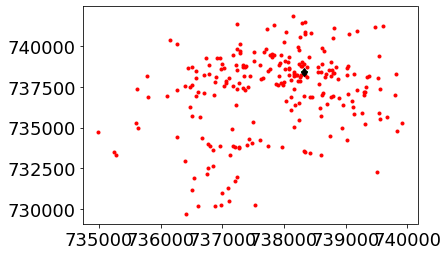

In [107]:
plot(gpos[phid==0,0][gpos[phid==0,0]<740000],gpos[phid==0,1][gpos[phid==0,0]<740000],'r.')
# plot(ds.halos[0].central_galaxy.pos[0],ds.halos[0].central_galaxy.pos[1],'bs')
plot(ds.halos[0].minpotpos[0],ds.halos[0].minpotpos[1],'g*')
plot(cc_data[i-1,4]/0.6777,cc_data[i-1,5]/0.6777,'kd')

In [38]:
ds.galaxies[1].info()

{'GroupID': 1,
 'L_FIR': 0.0 Lsun,
 'absmag': {'2mass_h': -25.981124877929688,
            '2mass_j': -25.737607955932617,
            '2mass_ks': -25.746068954467773,
            'b': -23.526586532592773,
            'bessell_l': -25.036794662475586,
            'bessell_lp': -24.91867446899414,
            'bessell_m': -24.440690994262695,
            'buser_b': -23.603601455688477,
            'cfht_b': -23.638200759887695,
            'cfht_i': -25.233776092529297,
            'cfht_r': -24.775022506713867,
            'cousins_i': -25.17528533935547,
            'cousins_r': -24.771602630615234,
            'des_g': -23.932506561279297,
            'des_i': -25.124149322509766,
            'des_r': -24.70415687561035,
            'des_y': -25.603187561035156,
            'des_z': -25.465185165405273,
            'fors_r': -24.767120361328125,
            'fors_v': -24.392087936401367,
            'galex_fuv': -16.09444808959961,
            'galex_nuv': -18.39063262939453,
       

In [130]:
ds.galaxies[dist.argmin()].parent_halo_index

0

In [47]:
ds.halos[dist.argmin()].minpotpos*0.6777

YTArray([500552.65085625, 501925.0357125 , 498870.8112375 ]) kpccm

In [22]:
from readsnapsgl import readsnap

In [112]:
# check on problemetic cluster
#42 [500428.9190648  500228.39994754 500330.29762365] [500438.88196875 500210.66649375 500340.10719375] 9.988339521918832
dmp=readsnap('/home2/weiguang/data7/Gizmo-Simba/NewMDCLUSTER_0151/snap_128.hdf5', 'Coordinates',ptype=1)
stp=readsnap('/home2/weiguang/data7/Gizmo-Simba/NewMDCLUSTER_0151/snap_128.hdf5', 'Coordinates',ptype=4)

reading files:  ['/home2/weiguang/data7/Gizmo-Simba/NewMDCLUSTER_0151/snap_128.hdf5']
Reading /home2/weiguang/data7/Gizmo-Simba/NewMDCLUSTER_0151/snap_128.hdf5 file with Header
Reading file  /home2/weiguang/data7/Gizmo-Simba/NewMDCLUSTER_0151/snap_128.hdf5  with data block  Coordinates  for type  1
reading files:  ['/home2/weiguang/data7/Gizmo-Simba/NewMDCLUSTER_0151/snap_128.hdf5']
Reading /home2/weiguang/data7/Gizmo-Simba/NewMDCLUSTER_0151/snap_128.hdf5 file with Header
Reading file  /home2/weiguang/data7/Gizmo-Simba/NewMDCLUSTER_0151/snap_128.hdf5  with data block  Coordinates  for type  4


In [117]:
# cc=np.array([500506.99339538, 500527.27929881, 500396.67926851])
cc=cc_data[i-1,4:7]
idp=(np.abs(dmp[:,0]-cc[0])<1000)&(np.abs(dmp[:,1]-cc[1])<1000)&(np.abs(dmp[:,2]-cc[2])<1000)
isp=(np.abs(stp[:,0]-cc[0])<1000)&(np.abs(stp[:,1]-cc[1])<1000)&(np.abs(stp[:,2]-cc[2])<1000)

11.098856423233137

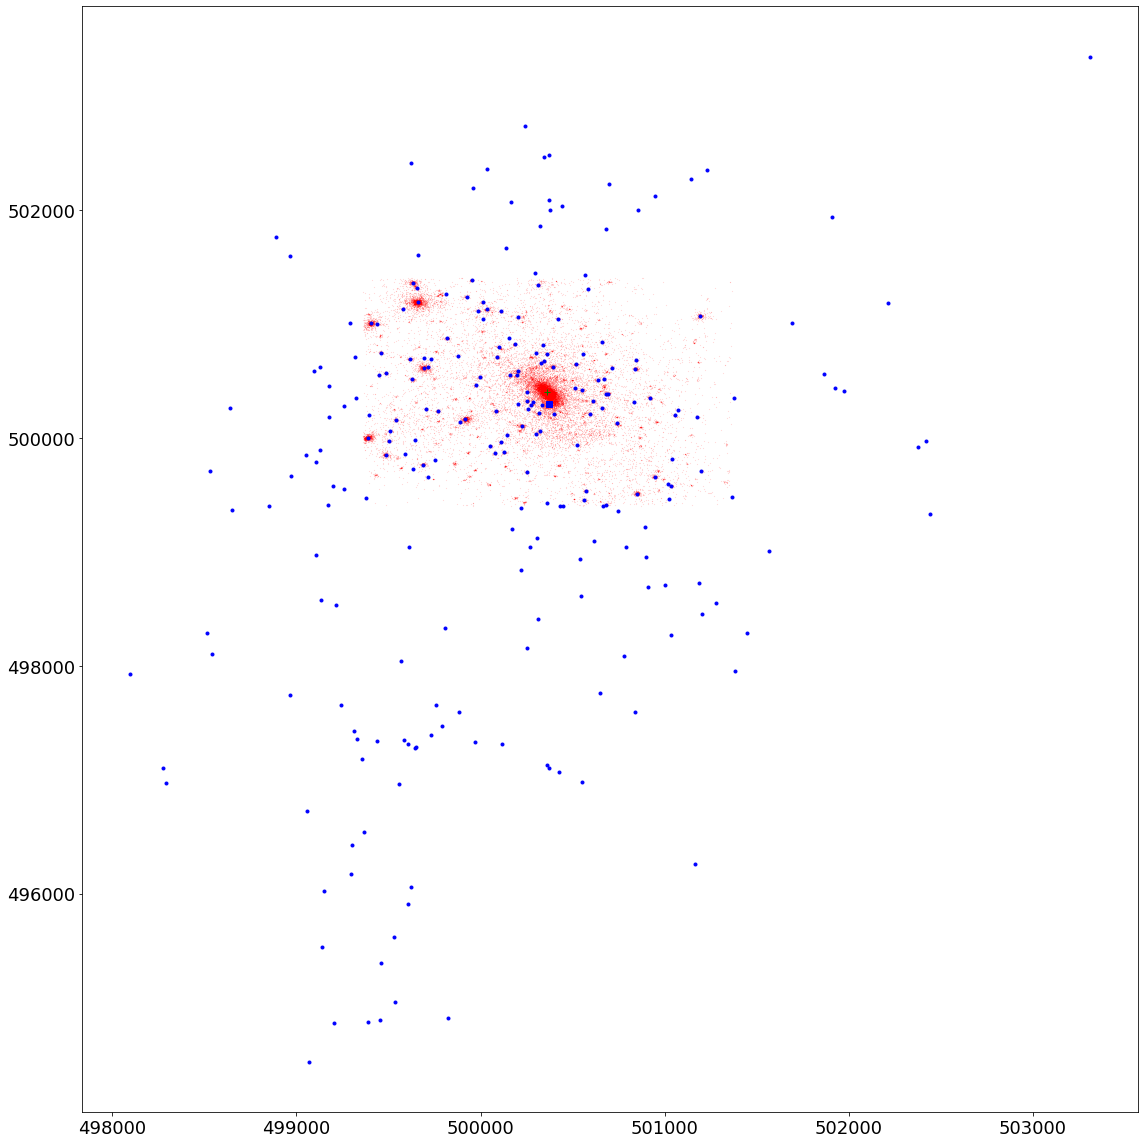

In [128]:
figure(figsize=(16,16))
# plot(dmp[idp,0],dmp[idp,1],'k.',ms=0.5)
plot(stp[isp,0],stp[isp,1],'r.',ms=0.1)
plot(gpos[phid==0,0][gpos[phid==0,0]<760000]*0.6777,gpos[phid==0,1][gpos[phid==0,0]<760000]*0.6777,'b.')
plot(gpos[dist.argmin(),0]*0.6777,gpos[dist.argmin(),1]*0.6777,'bs')
plot(cc[0],cc[1],'g+')
# plot(507719.07421875, 504794.62929375,'bo')
# plot(500044.12171875 ,499973.30206875,'ms')
# xlim(500200,500700);ylim(500000,500500);
tight_layout()
np.log10(gmas[dist.argmin()])

In [131]:
hs0list=ds.halos[0].slist

(497903.19762873, 503903.19762873)

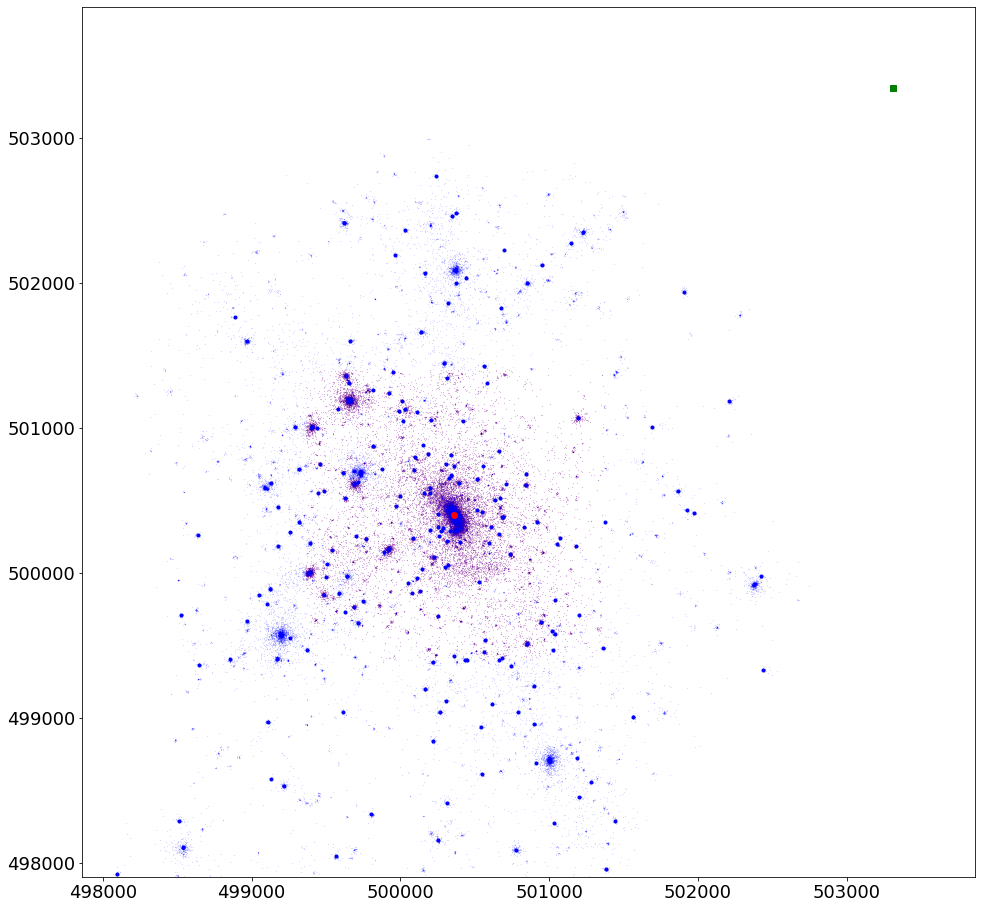

In [145]:
figure(figsize=(16,16))
# plot(dmp[idp,0],dmp[idp,1],'k.',ms=0.5)
plot(stp[isp,0],stp[isp,1],'r.',ms=0.1)
plot(stp[hs0list,0],stp[hs0list,1],'b.',ms=0.1)
plot(gpos[phid==0,0][gpos[phid==0,0]<760000]*0.6777,gpos[phid==0,1][gpos[phid==0,0]<760000]*0.6777,'b.')
plot(ds.galaxies[0].minpotpos.to('kpc/h')[0],ds.galaxies[0].minpotpos.to('kpc/h')[1],'ro')
plot(ds.galaxies[0].pos.to('kpc/h')[0],ds.galaxies[0].pos.to('kpc/h')[1],'gs')
xlim(cc[0]-2500,cc[0]+3500)
ylim(cc[1]-2500,cc[1]+3500)

In [142]:
ds.galaxies[0].pos.to('kpc/h'),ds.galaxies[0].minpotpos.to('kpc/h'),cc,ds.galaxies[0].parent_halo_index

(YTArray([503308.43319375, 503345.53726875, 503471.25061875]) kpc/h,
 YTArray([500362.89485625, 500400.634275  , 500524.94986875]) kpc/h,
 array([500363.68075381, 500403.19762873, 500524.37722013]),
 0)

# For GadgetX

In [4]:
# use distance between FoF halo and AHF halo centers, but check the central galaxy mass not always at the ahf halo center!!!
# use distance between galaxy and AHF halo center, but mark their parent FoF halo ID
gxccdata=np.loadtxt('../Halo_mass_function_mass-difference/G3X_Mass_snap_128-center-cluster.txt')
path='/home2/weiguang/data6/G3X_Caesar/'
Mac=np.copy(cc_data[:,:7])# region ID, AHF ID, Caesar Hid and Gid, 2 distances!
for i in np.arange(1,325):
    crg='NewMDCLUSTER_%04d' % i

    ds=caesar.load(path+crg+'/Caesar_snap_128.hdf5')
    hpos=np.array([j.pos for j in ds.halos])
    hids=np.array([j.GroupID for j in ds.halos])
    gpos=np.array([j.pos for j in ds.galaxies])  #CoM
    gmas=np.array([j.masses['stellar'] for j in ds.galaxies])  #CoM
    gids=np.array([j.GroupID for j in ds.galaxies])
    dist=np.linalg.norm(gpos-cc_data[i-1,4:7]/0.6777,axis=1)
    if (gmas[dist.argmin()] < 5e11):
        print(i, cc_data[i-1,4:7],gpos[dist.argmin()]*0.6777, np.log10(gmas[dist.argmin()]))
        # search for near largest galaxy
        idinr=dist<500
        print(np.log10(gmas[idinr].max()))
        maxmid=gmas[idinr].argmax()
        phi=ds.galaxies[np.where(gids==gids[idinr][maxmid])[0][0]].parent_halo_index
        Mac[i-1,2],Mac[i-1,3]=phi,gids[idinr][maxmid]
        Mac[i-1,4],Mac[i-1,5]=np.sqrt(np.sum((hpos[hids==phi] - cc_data[i-1,4:7]/0.6777)**2)),dist[idinr][maxmid]
        Mac[i-1,6] = np.log10(gmas[idinr][maxmid])
    else:
        phi=ds.galaxies[dist.argmin()].parent_halo_index
        Mac[i-1,2],Mac[i-1,3]=phi,gids[dist.argmin()]
        Mac[i-1,4],Mac[i-1,5]=np.sqrt(np.sum((hpos[hids==phi]-cc_data[i-1,4:7]/0.6777)**2)), dist.min()
        Mac[i-1,6] = np.log10(gmas[dist.argmin()])

np.savetxt('G3X-Matched-AHFhalo-Caesar-galaxy.txt',Mac,header="# region ID, AHF ID, Caesar Hid, Gid, dist hpos, gpos, select Mgal")

yt : [INFO     ] 2021-08-24 11:58:47,902 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0001/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:48,044 Found 2518 halos
yt : [INFO     ] 2021-08-24 11:58:48,054 Found 3038 galaxies


1 [500482.33416468 500428.43701958 500475.41034044] [500469.63260625 500392.20538125 500494.28394375] 9.183096387430231
12.503199369144843


yt : [INFO     ] 2021-08-24 11:58:48,339 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0002/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:48,658 Found 2176 halos
yt : [INFO     ] 2021-08-24 11:58:48,985 Found 2546 galaxies


2 [500527.66890452 500213.31400797 500389.23507204] [500526.13584375 500222.18739375 500409.8679375 ] 9.282716796423884
12.625057528343403


yt : [INFO     ] 2021-08-24 11:58:49,190 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0003/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:49,708 Found 2732 halos
yt : [INFO     ] 2021-08-24 11:58:49,981 Found 3945 galaxies


3 [500274.54185257 500375.34002492 500539.35013801] [500270.177025  500383.1835    500495.0887125] 9.20726843446033
12.494944042224978


yt : [INFO     ] 2021-08-24 11:58:50,297 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0004/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:50,704 Found 2642 halos
yt : [INFO     ] 2021-08-24 11:58:50,981 Found 3236 galaxies


4 [501336.03335785 501158.332553   501086.42693598] [501304.98256875 501091.67649375 501052.581675  ] 9.142594835089023
12.37343160225819


yt : [INFO     ] 2021-08-24 11:58:51,219 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0005/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:51,635 Found 2231 halos
yt : [INFO     ] 2021-08-24 11:58:51,991 Found 2478 galaxies


5 [499954.3889495  499892.79444553 500539.83710029] [499935.9862125 499894.053525  500567.9414625] 9.166200892713015
12.319499253772877


yt : [INFO     ] 2021-08-24 11:58:52,199 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0006/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:52,681 Found 2221 halos
yt : [INFO     ] 2021-08-24 11:58:53,108 Found 2524 galaxies
yt : [INFO     ] 2021-08-24 11:58:53,287 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0007/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:53,701 Found 2337 halos
yt : [INFO     ] 2021-08-24 11:58:53,942 Found 2740 galaxies


7 [500533.37042274 500461.52470448 500555.11812984] [500524.8228     500524.992225   500534.09881875] 11.002565109721104
12.591903369683497


yt : [INFO     ] 2021-08-24 11:58:54,145 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0008/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:54,524 Found 2394 halos
yt : [INFO     ] 2021-08-24 11:58:54,860 Found 2830 galaxies


8 [500333.69806078 500516.19450251 500758.02644094] [500376.36414375 500434.98519375 500728.00573125] 11.167471332490928
12.093083856813115


yt : [INFO     ] 2021-08-24 11:58:55,072 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0009/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:55,539 Found 2419 halos
yt : [INFO     ] 2021-08-24 11:58:55,762 Found 2801 galaxies


9 [500560.97656488 500508.83293152 500550.21941662] [500571.1605375 500534.0564625 500572.5159375] 9.165805237268483
12.36308837486349


yt : [INFO     ] 2021-08-24 11:58:56,000 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0010/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:56,453 Found 2521 halos
yt : [INFO     ] 2021-08-24 11:58:56,961 Found 3089 galaxies


10 [500761.27829914 500106.82368692 500403.01600307] [500743.211625  500108.2914375 500388.6051   ] 11.102866922292597
12.20127544402192


yt : [INFO     ] 2021-08-24 11:58:57,192 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0011/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:57,605 Found 1992 halos
yt : [INFO     ] 2021-08-24 11:58:57,873 Found 2190 galaxies


11 [500557.88088458 500224.89579927 500309.69921799] [500554.3874625 500184.5326875 500280.342525 ] 9.729792955055084
12.206104600473976


yt : [INFO     ] 2021-08-24 11:58:58,053 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0012/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:58,481 Found 2186 halos
yt : [INFO     ] 2021-08-24 11:58:58,814 Found 2431 galaxies


12 [500536.90570846 500488.27890479 500488.05599432] [500547.52575    500502.75519375 500508.049725  ] 10.175952944698835
12.23175290521922


yt : [INFO     ] 2021-08-24 11:58:59,007 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0013/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:58:59,443 Found 2448 halos
yt : [INFO     ] 2021-08-24 11:58:59,758 Found 2901 galaxies


13 [500384.25836889 500514.54567134 500472.10512607] [500402.1591     500528.93135625 500499.11255625] 9.192321833012343
12.163085817734943


yt : [INFO     ] 2021-08-24 11:58:59,976 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0014/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:00,403 Found 2009 halos
yt : [INFO     ] 2021-08-24 11:59:00,802 Found 2212 galaxies


14 [500510.4439361  500454.29921889 500394.10436308] [500519.4012     500398.72824375 500352.05165625] 10.888179670827276
12.027508875767019


yt : [INFO     ] 2021-08-24 11:59:00,969 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0015/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:01,253 Found 1857 halos
yt : [INFO     ] 2021-08-24 11:59:01,591 Found 1916 galaxies
yt : [INFO     ] 2021-08-24 11:59:01,754 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0016/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:02,228 Found 2916 halos
yt : [INFO     ] 2021-08-24 11:59:02,652 Found 4034 galaxies


16 [500622.23671013 500719.28447364 500673.67561127] [500598.48031875 500687.51315625 500720.63574375] 9.297399980650086
12.375615435457817


yt : [INFO     ] 2021-08-24 11:59:02,940 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0017/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:03,278 Found 1928 halos
yt : [INFO     ] 2021-08-24 11:59:03,599 Found 2157 galaxies


17 [500446.56131003 500299.75672563 500378.11862098] [500457.26458125 500278.09764375 500363.1066375 ] 9.471876323807503
12.388784443278043


yt : [INFO     ] 2021-08-24 11:59:03,779 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0018/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:04,272 Found 2761 halos
yt : [INFO     ] 2021-08-24 11:59:04,837 Found 3653 galaxies


18 [500618.04465065 500567.3221464  500485.74241715] [500623.3434375  500506.05898125 500481.619425  ] 9.155959554814471
12.49322865100723


yt : [INFO     ] 2021-08-24 11:59:05,213 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0019/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:05,541 Found 1925 halos
yt : [INFO     ] 2021-08-24 11:59:05,809 Found 2259 galaxies


19 [500633.95659129 500534.9890391  500610.43103536] [500627.1555     500526.51705    500595.76951875] 9.211347011910352
12.42664953235104


yt : [INFO     ] 2021-08-24 11:59:05,993 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0020/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:06,399 Found 2607 halos
yt : [INFO     ] 2021-08-24 11:59:06,862 Found 3611 galaxies


20 [500345.56126915 500516.28801587 500561.01953101] [500318.59021875 500517.6222375  500569.84749375] 9.192770176380279
12.317401840906726


yt : [INFO     ] 2021-08-24 11:59:07,123 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0021/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:07,598 Found 2329 halos
yt : [INFO     ] 2021-08-24 11:59:07,987 Found 2648 galaxies


21 [500379.55685898 500290.78505657 500497.09046329] [500401.82025    500298.0474375  500492.25084375] 9.369206877443709
12.344674794139792


yt : [INFO     ] 2021-08-24 11:59:08,218 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0022/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:08,619 Found 2197 halos
yt : [INFO     ] 2021-08-24 11:59:08,826 Found 2325 galaxies
yt : [INFO     ] 2021-08-24 11:59:08,997 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0023/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:09,365 Found 2466 halos
yt : [INFO     ] 2021-08-24 11:59:09,727 Found 2830 galaxies


23 [500365.70981697 500184.3991103  500542.77093322] [500308.29765    500173.7742     500566.62841875] 10.741082393753933
11.993105274978316


yt : [INFO     ] 2021-08-24 11:59:13,953 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0024/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:14,311 Found 2316 halos
yt : [INFO     ] 2021-08-24 11:59:14,669 Found 2629 galaxies
yt : [INFO     ] 2021-08-24 11:59:14,853 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0025/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:15,266 Found 2206 halos
yt : [INFO     ] 2021-08-24 11:59:15,555 Found 2407 galaxies


25 [500600.17028097 500352.96557313 500381.3909272 ] [500569.6357125  500315.1593625  500428.88589375] 9.646353341219159
12.51881067127676


yt : [INFO     ] 2021-08-24 11:59:15,747 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0026/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:16,195 Found 2420 halos
yt : [INFO     ] 2021-08-24 11:59:16,417 Found 2998 galaxies


26 [500588.5826585  500563.63364077 500709.54850972] [500631.56055    500554.26039375 500623.21636875] 9.303690524099498
12.82498993008438


yt : [INFO     ] 2021-08-24 11:59:16,633 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0027/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:17,020 Found 2251 halos
yt : [INFO     ] 2021-08-24 11:59:17,403 Found 2503 galaxies


27 [500311.06800273 500489.34981443 500267.85463527] [500326.12963125 500478.95098125 500305.37506875] 9.154085180174551
12.423999117448416


yt : [INFO     ] 2021-08-24 11:59:17,597 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0028/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:22,804 Found 1913 halos
yt : [INFO     ] 2021-08-24 11:59:23,203 Found 2100 galaxies


28 [500703.19346019 500485.20645701 500557.33784697] [500679.55018125 500452.69010625 500551.97315625] 9.468362305336766
12.548739810602925


yt : [INFO     ] 2021-08-24 11:59:23,383 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0029/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:23,757 Found 2111 halos
yt : [INFO     ] 2021-08-24 11:59:23,993 Found 2339 galaxies


29 [500381.18533167 500502.28060166 500524.72424466] [500393.39135625 500510.80288125 500532.9552    ] 9.25224919924855
12.67000409777468


yt : [INFO     ] 2021-08-24 11:59:24,176 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0030/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:24,497 Found 2303 halos
yt : [INFO     ] 2021-08-24 11:59:24,892 Found 2566 galaxies


30 [500480.40993073 500398.90934439 500502.16913223] [500493.86038125 500410.122075   500467.17594375] 9.181428002495371
12.802998607926387


yt : [INFO     ] 2021-08-24 11:59:25,095 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0031/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:25,462 Found 2089 halos
yt : [INFO     ] 2021-08-24 11:59:25,732 Found 2266 galaxies


31 [500425.07981325 500461.73279936 500545.26599971] [500424.14199375 500435.83231875 500562.39279375] 9.267269014493884
12.348588679767524


yt : [INFO     ] 2021-08-24 11:59:25,935 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0032/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:26,327 Found 1800 halos
yt : [INFO     ] 2021-08-24 11:59:26,635 Found 1841 galaxies


32 [500292.95879406 500495.49537701 500359.42452294] [500280.1731     500460.48365625 500315.11700625] 9.369305076830353
12.750094552357984


yt : [INFO     ] 2021-08-24 11:59:26,803 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0033/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:27,188 Found 1943 halos
yt : [INFO     ] 2021-08-24 11:59:27,432 Found 2002 galaxies


33 [500445.57322627 500514.22395568 500357.05082658] [500446.42138125 500513.9796     500406.56415   ] 9.220843659838982
12.766558796552292


yt : [INFO     ] 2021-08-24 11:59:27,618 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0034/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:28,004 Found 1853 halos
yt : [INFO     ] 2021-08-24 11:59:28,355 Found 1832 galaxies
yt : [INFO     ] 2021-08-24 11:59:28,519 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0035/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:28,896 Found 1943 halos
yt : [INFO     ] 2021-08-24 11:59:29,211 Found 2193 galaxies
yt : [INFO     ] 2021-08-24 11:59:29,403 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0036/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:29,787 Found 1913 halos
yt : [INFO     ] 2021-08-24 11:59:29,951 Found 1979 galaxies
yt : [INFO     ] 2021-08-24 11:59:30,106 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0037/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:30,494 Found 2188 halos
yt : [INFO     ] 2021-08-24 11:59:30,940 Found 2470 galaxies


37 [500464.09442059 500423.14765443 500556.96777839] [500497.0371    500441.0421375 500584.4604   ] 9.666191891701597
12.508628069358641


yt : [INFO     ] 2021-08-24 11:59:31,139 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0038/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:31,545 Found 1731 halos
yt : [INFO     ] 2021-08-24 11:59:31,857 Found 1765 galaxies


38 [500431.827504   500327.20377119 500754.43614301] [500439.09375   500317.10775   500784.4666125] 9.178241252051226
12.038081878745924


yt : [INFO     ] 2021-08-24 11:59:32,011 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0039/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:32,431 Found 2310 halos
yt : [INFO     ] 2021-08-24 11:59:32,752 Found 3038 galaxies


39 [500609.13415804 500438.70488258 500552.12925558] [500606.4009375  500435.57818125 500527.74538125] 9.246810766672986
12.486679604974817


yt : [INFO     ] 2021-08-24 11:59:33,005 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0040/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:33,434 Found 2454 halos
yt : [INFO     ] 2021-08-24 11:59:33,807 Found 2771 galaxies


40 [500369.46003155 500356.36944156 500595.3020306 ] [500382.12459375 500365.5633     500575.480875  ] 9.450188231367017
12.271124786263055


yt : [INFO     ] 2021-08-24 11:59:34,031 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0041/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:34,458 Found 2046 halos
yt : [INFO     ] 2021-08-24 11:59:34,685 Found 1986 galaxies


41 [500371.00627821 500330.79293948 500470.27498089] [500397.11870625 500304.01966875 500478.44270625] 9.164665035794846
12.55225027892913


yt : [INFO     ] 2021-08-24 11:59:34,855 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0042/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:35,213 Found 2087 halos
yt : [INFO     ] 2021-08-24 11:59:35,459 Found 2145 galaxies


42 [500428.9190648  500228.39994754 500330.29762365] [500380.3879875  500235.23311875 500334.60088125] 9.177194350058741
12.240614362829469


yt : [INFO     ] 2021-08-24 11:59:35,635 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0043/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:36,003 Found 2090 halos
yt : [INFO     ] 2021-08-24 11:59:36,276 Found 2309 galaxies


43 [500266.28235042 500331.3190185  500351.57339685] [500281.359075  500328.5439375 500317.78545  ] 9.168968119137997
12.322829698676857


yt : [INFO     ] 2021-08-24 11:59:36,463 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0044/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:36,837 Found 1957 halos
yt : [INFO     ] 2021-08-24 11:59:37,048 Found 2181 galaxies


44 [500535.04720253 500423.23014414 500414.39708485] [500543.967825   500414.7812625  500400.67663125] 9.167911322107871
12.179004701788136


yt : [INFO     ] 2021-08-24 11:59:37,205 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0045/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:37,501 Found 1970 halos
yt : [INFO     ] 2021-08-24 11:59:37,722 Found 2262 galaxies


45 [500465.55392713 500615.67791973 500489.35844238] [500447.69206875 500619.9549375  500504.5765125 ] 10.22913463862128
12.80118423802819


yt : [INFO     ] 2021-08-24 11:59:37,902 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0046/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:38,220 Found 2436 halos
yt : [INFO     ] 2021-08-24 11:59:38,510 Found 2473 galaxies


46 [500245.6928182  500449.80266707 500455.28252869] [500244.3397125  500466.20175    500465.73583125] 9.145598061783481
12.539012571771647


yt : [INFO     ] 2021-08-24 11:59:38,722 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0047/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:39,237 Found 2264 halos
yt : [INFO     ] 2021-08-24 11:59:39,697 Found 2605 galaxies


47 [500480.68186916 500526.72920498 500515.00230816] [500497.07945625 500525.28871875 500546.12799375] 9.176530047657314
12.112141795396623


yt : [INFO     ] 2021-08-24 11:59:39,894 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0048/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:40,204 Found 1717 halos
yt : [INFO     ] 2021-08-24 11:59:40,507 Found 1604 galaxies


48 [500352.47206688 500369.95278464 500243.70352427] [500338.07409375 500381.5739625  500259.7573875 ] 9.25462978348813
12.277842925577774


yt : [INFO     ] 2021-08-24 11:59:40,655 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0049/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:41,012 Found 1848 halos
yt : [INFO     ] 2021-08-24 11:59:41,338 Found 1827 galaxies


49 [500174.23033714 500577.92365551 500577.3037672 ] [500150.43590625 500577.175125   500615.33810625] 10.408241841459958
12.363521992273485


yt : [INFO     ] 2021-08-24 11:59:41,495 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0050/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:41,878 Found 1782 halos
yt : [INFO     ] 2021-08-24 11:59:42,108 Found 1828 galaxies


50 [500233.86024293 500375.66678865 500479.85003108] [500222.86509375 500377.0842     500463.53330625] 9.584760731824261
12.544446620332034


yt : [INFO     ] 2021-08-24 11:59:42,276 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0051/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:42,601 Found 2050 halos
yt : [INFO     ] 2021-08-24 11:59:42,922 Found 2236 galaxies


51 [500326.61600258 500477.43989034 500686.78511413] [500383.52235    500446.379025   500690.05453125] 9.311171215808162
12.287471904423224


yt : [INFO     ] 2021-08-24 11:59:43,105 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0052/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:43,512 Found 2113 halos
yt : [INFO     ] 2021-08-24 11:59:43,781 Found 2321 galaxies


52 [500470.1795549  500557.06881462 500508.84575829] [500453.11366875 500529.77848125 500507.1178875 ] 9.165794991184038
12.441929646345583


yt : [INFO     ] 2021-08-24 11:59:43,960 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0053/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:44,253 Found 1624 halos
yt : [INFO     ] 2021-08-24 11:59:44,531 Found 1682 galaxies


53 [500188.36611725 500378.63060652 500318.76779464] [500177.8404     500397.79640625 500326.9344    ] 9.20501519996537
12.51821424537663


yt : [INFO     ] 2021-08-24 11:59:44,692 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0054/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:44,996 Found 1870 halos
yt : [INFO     ] 2021-08-24 11:59:45,303 Found 2097 galaxies
yt : [INFO     ] 2021-08-24 11:59:45,451 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0055/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:45,824 Found 2176 halos
yt : [INFO     ] 2021-08-24 11:59:46,115 Found 2236 galaxies


55 [500407.64158422 500267.50564575 500419.16695508] [500392.6713     500246.33045625 500438.585475  ] 9.446574821692943
12.271076486079807


yt : [INFO     ] 2021-08-24 11:59:46,289 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0056/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:46,668 Found 1936 halos
yt : [INFO     ] 2021-08-24 11:59:46,935 Found 2237 galaxies


56 [500598.97535694 500518.17516372 500595.82892309] [500573.8713375  500496.82531875 500549.050575  ] 9.211455078743892
12.638700279157922


yt : [INFO     ] 2021-08-24 11:59:47,117 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0057/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:47,470 Found 1873 halos
yt : [INFO     ] 2021-08-24 11:59:47,790 Found 1786 galaxies


57 [499523.09306595 500987.14111528 500514.42293677] [499484.76508125 500976.679275   500482.1277    ] 9.226082646132951
12.382990722241365


yt : [INFO     ] 2021-08-24 11:59:47,947 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0058/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:48,360 Found 1962 halos
yt : [INFO     ] 2021-08-24 11:59:48,617 Found 2110 galaxies
yt : [INFO     ] 2021-08-24 11:59:48,786 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0059/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:49,107 Found 1713 halos
yt : [INFO     ] 2021-08-24 11:59:49,554 Found 1696 galaxies


59 [500401.51880068 500093.21552866 500193.22949297] [500402.9215125  500139.25385625 500210.200575  ] 9.178836698727398
12.664954196135012


yt : [INFO     ] 2021-08-24 11:59:49,710 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0060/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:50,075 Found 2077 halos
yt : [INFO     ] 2021-08-24 11:59:50,405 Found 2215 galaxies


60 [500493.04664135 500298.04309209 500479.92567221] [500506.82139375 500292.541125   500491.446075  ] 10.284703482396493
12.225754015021874


yt : [INFO     ] 2021-08-24 11:59:50,595 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0061/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:50,957 Found 1754 halos
yt : [INFO     ] 2021-08-24 11:59:51,197 Found 1854 galaxies


61 [500589.10298992 500459.86497724 500427.02314016] [500552.22729375 500428.5894     500399.82950625] 9.192503188608743
12.349851714943787


yt : [INFO     ] 2021-08-24 11:59:51,371 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0062/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:51,672 Found 1839 halos
yt : [INFO     ] 2021-08-24 11:59:51,930 Found 1648 galaxies


62 [500548.76855315 500227.47658442 499187.91696041] [500534.94594375 500188.0906125  499168.44860625] 10.371745711773983
11.766833830124165


yt : [INFO     ] 2021-08-24 11:59:52,097 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0063/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:52,468 Found 1841 halos
yt : [INFO     ] 2021-08-24 11:59:52,748 Found 2050 galaxies
yt : [INFO     ] 2021-08-24 11:59:52,915 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0064/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:53,276 Found 2105 halos
yt : [INFO     ] 2021-08-24 11:59:53,566 Found 2389 galaxies


64 [500457.22323926 500639.85431684 500478.99142197] [500455.9515375  500713.3081125  500483.18660625] 10.691288831804814
12.203714629173604


yt : [INFO     ] 2021-08-24 11:59:53,755 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0065/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:54,185 Found 1920 halos
yt : [INFO     ] 2021-08-24 11:59:54,433 Found 1902 galaxies
yt : [INFO     ] 2021-08-24 11:59:54,581 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0066/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:54,995 Found 2295 halos
yt : [INFO     ] 2021-08-24 11:59:55,234 Found 2392 galaxies


66 [500369.18653525 500110.39494696 500508.57669591] [500399.78715    500073.7287375  500502.16220625] 9.443604454354935
12.275281375887483


yt : [INFO     ] 2021-08-24 11:59:55,445 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0067/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:55,803 Found 1850 halos
yt : [INFO     ] 2021-08-24 11:59:56,010 Found 1940 galaxies
yt : [INFO     ] 2021-08-24 11:59:56,170 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0068/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:56,616 Found 2424 halos
yt : [INFO     ] 2021-08-24 11:59:56,948 Found 3412 galaxies


68 [500625.48952551 500330.58309641 500654.59965797] [500587.04413125 500356.71084375 500651.51034375] 9.520494876914736
12.45836620710245


yt : [INFO     ] 2021-08-24 11:59:57,195 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0069/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:57,585 Found 1737 halos
yt : [INFO     ] 2021-08-24 11:59:57,888 Found 1893 galaxies
yt : [INFO     ] 2021-08-24 11:59:58,032 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0070/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:58,436 Found 2026 halos
yt : [INFO     ] 2021-08-24 11:59:58,750 Found 2215 galaxies
yt : [INFO     ] 2021-08-24 11:59:58,912 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0071/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 11:59:59,210 Found 1829 halos
yt : [INFO     ] 2021-08-24 11:59:59,551 Found 1850 galaxies


71 [500514.28235356 500134.5057184  500433.70865498] [500499.79025625 500121.88779375 500399.7024375 ] 9.9949272137205
12.435968957055744


yt : [INFO     ] 2021-08-24 11:59:59,730 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0072/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:00,093 Found 2214 halos
yt : [INFO     ] 2021-08-24 12:00:00,469 Found 2587 galaxies


72 [500210.04058127 500414.43344049 500438.85419941] [500211.3018375  500378.8631625  500459.63653125] 9.370991425630617
12.684549709467383


yt : [INFO     ] 2021-08-24 12:00:00,710 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0073/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:00,999 Found 2003 halos
yt : [INFO     ] 2021-08-24 12:00:01,352 Found 2140 galaxies


73 [499652.74333954 499520.81811356 500054.92359988] [499643.5586625 499485.6545625 500031.3724875] 9.299841335947995
12.238818673720527


yt : [INFO     ] 2021-08-24 12:00:01,521 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0074/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:01,961 Found 2451 halos
yt : [INFO     ] 2021-08-24 12:00:02,346 Found 3004 galaxies


74 [500408.74159784 500534.46833998 500448.16732407] [500396.01744375 500530.79503125 500407.45363125] 9.212924412126204
12.691114055186217


yt : [INFO     ] 2021-08-24 12:00:02,563 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0075/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:02,909 Found 1901 halos
yt : [INFO     ] 2021-08-24 12:00:03,255 Found 1918 galaxies


75 [500353.18068576 500489.72198556 500413.08923798] [500387.29205625 500488.01521875 500428.419975  ] 9.26198631784868
12.399842095578002


yt : [INFO     ] 2021-08-24 12:00:03,471 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0076/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:03,839 Found 2103 halos
yt : [INFO     ] 2021-08-24 12:00:04,134 Found 2126 galaxies


76 [500444.37646866 500452.76165009 500480.45158386] [500428.8435375  500435.6205375  500494.19923125] 10.178750708269536
12.341415022313349


yt : [INFO     ] 2021-08-24 12:00:04,324 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0077/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:04,748 Found 1738 halos
yt : [INFO     ] 2021-08-24 12:00:05,091 Found 1895 galaxies


77 [500464.92181718 500367.95902997 500300.71288347] [500463.95686875 500375.898225   500248.151775  ] 9.203648395592287
12.439726325715403


yt : [INFO     ] 2021-08-24 12:00:05,267 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0078/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:05,629 Found 2179 halos
yt : [INFO     ] 2021-08-24 12:00:05,970 Found 2574 galaxies
yt : [INFO     ] 2021-08-24 12:00:06,164 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0079/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:06,624 Found 2568 halos
yt : [INFO     ] 2021-08-24 12:00:06,868 Found 3022 galaxies


79 [500549.28175771 500391.01272783 500411.51054385] [500559.893775  500401.82025   500408.0042625] 9.517525104063003
12.572645833675354


yt : [INFO     ] 2021-08-24 12:00:07,077 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0080/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:07,469 Found 3150 halos
yt : [INFO     ] 2021-08-24 12:00:07,768 Found 4035 galaxies
yt : [INFO     ] 2021-08-24 12:00:08,056 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0081/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:08,426 Found 1839 halos
yt : [INFO     ] 2021-08-24 12:00:08,743 Found 1869 galaxies
yt : [INFO     ] 2021-08-24 12:00:08,886 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0082/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:09,292 Found 2244 halos
yt : [INFO     ] 2021-08-24 12:00:09,655 Found 2649 galaxies


82 [500436.78609178 500474.09086911 500619.69871   ] [500432.99445    500439.22081875 500655.8730375 ] 9.153939464908287
12.774833696360787


yt : [INFO     ] 2021-08-24 12:00:09,871 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0083/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:10,268 Found 2051 halos
yt : [INFO     ] 2021-08-24 12:00:10,598 Found 1946 galaxies


83 [500717.89063513 500414.58420455 500591.11826122] [500732.6225625  500445.57425625 500589.58550625] 9.458894095075197
12.54739099021882


yt : [INFO     ] 2021-08-24 12:00:10,762 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0084/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:11,125 Found 1820 halos
yt : [INFO     ] 2021-08-24 12:00:11,446 Found 1702 galaxies


84 [500377.37161118 500302.42844133 500439.31860008] [500381.2351125 500292.1175625 500429.3518125] 9.163594575198811
12.610226157469935


yt : [INFO     ] 2021-08-24 12:00:11,595 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0085/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:11,965 Found 2152 halos
yt : [INFO     ] 2021-08-24 12:00:12,179 Found 2351 galaxies
yt : [INFO     ] 2021-08-24 12:00:18,271 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0086/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:18,598 Found 1813 halos
yt : [INFO     ] 2021-08-24 12:00:18,871 Found 1726 galaxies


86 [500108.10780993 500591.08109071 500264.93999919] [500056.06618125 500592.084525   500277.80115   ] 9.558435296549163
11.897507593882649


yt : [INFO     ] 2021-08-24 12:00:19,035 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0087/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:19,352 Found 1522 halos
yt : [INFO     ] 2021-08-24 12:00:19,695 Found 1561 galaxies


87 [500407.35304356 500456.83607459 500409.22313929] [500407.45363125 500460.6954375  500420.626425  ] 9.21518254190676
12.170560850771016


yt : [INFO     ] 2021-08-24 12:00:19,847 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0088/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:20,310 Found 2225 halos
yt : [INFO     ] 2021-08-24 12:00:20,609 Found 2265 galaxies
yt : [INFO     ] 2021-08-24 12:00:20,787 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0089/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:21,141 Found 1874 halos
yt : [INFO     ] 2021-08-24 12:00:21,424 Found 1858 galaxies


89 [500398.4670511  500057.79290359 500394.6955572 ] [500402.70973125 500044.46056875 500412.155175  ] 9.254361516143556
12.578835090855794


yt : [INFO     ] 2021-08-24 12:00:21,581 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0090/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:22,057 Found 2945 halos
yt : [INFO     ] 2021-08-24 12:00:22,347 Found 3981 galaxies


90 [501008.95987617 499927.3769723  500188.87758255] [500968.41980625 499907.39574375 500233.45415625] 9.323145727292303
12.075218042235337


yt : [INFO     ] 2021-08-24 12:00:22,620 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0091/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:23,079 Found 2050 halos
yt : [INFO     ] 2021-08-24 12:00:23,267 Found 2064 galaxies
yt : [INFO     ] 2021-08-24 12:00:23,433 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0092/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:23,814 Found 1825 halos
yt : [INFO     ] 2021-08-24 12:00:24,136 Found 1953 galaxies
yt : [INFO     ] 2021-08-24 12:00:24,292 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0093/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:24,654 Found 1949 halos
yt : [INFO     ] 2021-08-24 12:00:24,896 Found 1990 galaxies


93 [500577.06924585 500340.34252167 500422.60151643] [500538.58858125 500313.4651125  500462.7285375 ] 10.35179098528876
12.598571842803697


yt : [INFO     ] 2021-08-24 12:00:25,069 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0094/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:25,483 Found 1789 halos
yt : [INFO     ] 2021-08-24 12:00:25,712 Found 1751 galaxies


94 [500208.15317447 500481.7792675  500357.60543504] [500146.87798125 500478.10385625 500374.881675  ] 9.446331142095044
12.195059761031443


yt : [INFO     ] 2021-08-24 12:00:25,891 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0095/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:26,351 Found 2077 halos
yt : [INFO     ] 2021-08-24 12:00:26,585 Found 2205 galaxies


95 [500217.22557602 500383.77821334 500339.6964717 ] [500231.16691875 500367.93525    500354.2965375 ] 9.585660532099128
12.201740811736842


yt : [INFO     ] 2021-08-24 12:00:26,785 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0096/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:27,126 Found 1782 halos
yt : [INFO     ] 2021-08-24 12:00:27,495 Found 1771 galaxies


96 [500219.20960224 500257.5292874  500373.01575627] [500203.6777125  500227.01600625 500365.94450625] 9.27275843287341
12.456262714819552


yt : [INFO     ] 2021-08-24 12:00:27,664 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0097/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:28,042 Found 2374 halos
yt : [INFO     ] 2021-08-24 12:00:28,390 Found 2594 galaxies


97 [500513.06157571 500562.83334728 500581.47030287] [500481.8735625  500537.1061125  500593.65170625] 9.174301032755578
12.499187473809224


yt : [INFO     ] 2021-08-24 12:00:28,607 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0098/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:28,936 Found 1813 halos
yt : [INFO     ] 2021-08-24 12:00:29,139 Found 1952 galaxies


98 [500539.72653721 500444.67267783 500293.40256815] [500557.14061875 500441.93161875 500265.6872625 ] 9.21819464094377
12.613379904205743


yt : [INFO     ] 2021-08-24 12:00:29,293 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0099/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:29,668 Found 1811 halos
yt : [INFO     ] 2021-08-24 12:00:29,994 Found 1803 galaxies


99 [500436.04346427 500425.59229127 500372.88816712] [500433.03680625 500460.949575   500381.44689375] 10.344410197847223
12.279279809358304


yt : [INFO     ] 2021-08-24 12:00:30,157 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0100/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:30,554 Found 1760 halos
yt : [INFO     ] 2021-08-24 12:00:30,898 Found 1795 galaxies


100 [500435.18748291 500296.87560831 500203.24455144] [500459.63653125 500365.35151875 500213.5043625 ] 10.369030471356659
12.144949442063606


yt : [INFO     ] 2021-08-24 12:00:31,047 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0101/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:31,477 Found 2704 halos
yt : [INFO     ] 2021-08-24 12:00:31,820 Found 3283 galaxies


101 [500599.5850814  500312.52283799 500513.52224852] [500639.9470875  500295.42135    500516.90218125] 9.384647494839161
12.508746639723089


yt : [INFO     ] 2021-08-24 12:00:32,091 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0102/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:32,526 Found 1874 halos
yt : [INFO     ] 2021-08-24 12:00:32,821 Found 1758 galaxies


102 [500571.92572526 500344.29594165 500247.25993474] [500593.90584375 500359.12515    500255.98768125] 9.267798747973874
12.470242009860398


yt : [INFO     ] 2021-08-24 12:00:32,974 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0103/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:33,347 Found 2025 halos
yt : [INFO     ] 2021-08-24 12:00:33,600 Found 2165 galaxies


103 [500694.3535559  500562.51822059 500436.04622797] [500732.707275   500577.9375375  500420.07579375] 9.135207965826522
12.521691198397223


yt : [INFO     ] 2021-08-24 12:00:33,780 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0104/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:34,185 Found 2259 halos
yt : [INFO     ] 2021-08-24 12:00:34,470 Found 2370 galaxies
yt : [INFO     ] 2021-08-24 12:00:34,651 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0105/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:35,100 Found 2157 halos
yt : [INFO     ] 2021-08-24 12:00:35,376 Found 2343 galaxies


105 [500358.52107449 500393.53318836 500623.09810217] [500373.90748125 500405.08168125 500597.97204375] 9.223539882176247
12.267593778727896


yt : [INFO     ] 2021-08-24 12:00:35,564 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0106/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:35,922 Found 2166 halos
yt : [INFO     ] 2021-08-24 12:00:36,221 Found 2351 galaxies


106 [500536.311722   500301.00377215 500422.6886455 ] [500611.22955    500293.9812375  500446.42138125] 9.349214160543458
12.445012552608306


yt : [INFO     ] 2021-08-24 12:00:36,413 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0107/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:36,733 Found 1467 halos
yt : [INFO     ] 2021-08-24 12:00:36,986 Found 1458 galaxies


107 [500231.77552921 500522.90730895 500265.81177652] [500226.08416875 500520.1636125  500255.267625  ] 9.185947212229978
12.415258185077468


yt : [INFO     ] 2021-08-24 12:00:37,119 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0108/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:37,496 Found 1792 halos
yt : [INFO     ] 2021-08-24 12:00:37,758 Found 1811 galaxies
yt : [INFO     ] 2021-08-24 12:00:37,893 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0109/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:38,250 Found 1876 halos
yt : [INFO     ] 2021-08-24 12:00:38,511 Found 2019 galaxies


109 [500450.54793153 500472.59899192 500744.10009139] [500450.2758    500466.710025  500685.0141375] 9.143787808457303
12.481946583024902


yt : [INFO     ] 2021-08-24 12:00:38,679 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0110/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:39,118 Found 2525 halos
yt : [INFO     ] 2021-08-24 12:00:39,419 Found 3502 galaxies


110 [500526.67150692 500485.43198579 500595.87331045] [500515.9279875  500424.14199375 500590.77148125] 9.156954797605136
12.350919207155814


yt : [INFO     ] 2021-08-24 12:00:39,660 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0111/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:40,063 Found 2658 halos
yt : [INFO     ] 2021-08-24 12:00:40,544 Found 3262 galaxies
yt : [INFO     ] 2021-08-24 12:00:40,790 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0112/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:41,134 Found 1652 halos
yt : [INFO     ] 2021-08-24 12:00:41,374 Found 1565 galaxies


112 [500376.74193687 500458.73129621 500277.47864419] [500396.1445125 500486.1939    500273.3113875] 10.971177382052229
12.00257605948166


yt : [INFO     ] 2021-08-24 12:00:41,522 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0113/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:41,822 Found 1751 halos
yt : [INFO     ] 2021-08-24 12:00:42,089 Found 1722 galaxies
yt : [INFO     ] 2021-08-24 12:00:42,229 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0114/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:42,567 Found 1977 halos
yt : [INFO     ] 2021-08-24 12:00:42,835 Found 1956 galaxies


114 [500128.71088126 500457.72240712 500251.94577682] [500167.29369375 500514.99615    500215.622175  ] 9.910547214403488
12.456351177753868


yt : [INFO     ] 2021-08-24 12:00:43,007 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0115/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:43,450 Found 2146 halos
yt : [INFO     ] 2021-08-24 12:00:43,674 Found 2316 galaxies


115 [500484.68228863 500301.44755723 500502.0726414 ] [500502.16220625 500282.2909125  500481.0264375 ] 9.20789839846951
12.218073723914344


yt : [INFO     ] 2021-08-24 12:00:43,867 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0116/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:44,160 Found 1825 halos
yt : [INFO     ] 2021-08-24 12:00:44,462 Found 1650 galaxies


116 [500617.75828308 500774.57697886 500608.31600765] [500605.93501875 500738.63715    500603.266575  ] 9.204852696504588
12.312063727511878


yt : [INFO     ] 2021-08-24 12:00:44,618 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0117/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:44,938 Found 2110 halos
yt : [INFO     ] 2021-08-24 12:00:45,334 Found 2598 galaxies
yt : [INFO     ] 2021-08-24 12:00:45,547 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0118/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:45,849 Found 1643 halos
yt : [INFO     ] 2021-08-24 12:00:46,117 Found 1682 galaxies


118 [500280.30688946 500440.02746924 500404.28607892] [500253.234525  500431.0460625 500365.732725 ] 9.504904445684673
11.926845803759543


yt : [INFO     ] 2021-08-24 12:00:46,267 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0119/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:46,726 Found 1761 halos
yt : [INFO     ] 2021-08-24 12:00:46,986 Found 1821 galaxies


119 [500302.25149973 500320.42886106 500503.38611749] [500340.78489375 500354.211825   500516.39390625] 9.156749328878691
12.455246528316291


yt : [INFO     ] 2021-08-24 12:00:47,158 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0120/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:47,494 Found 2328 halos
yt : [INFO     ] 2021-08-24 12:00:47,814 Found 2521 galaxies


120 [500212.62963613 500294.34760412 500167.09168752] [500207.27799375 500304.400875   500194.14755625] 9.203814861796607
12.660286868841391


yt : [INFO     ] 2021-08-24 12:00:48,016 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0121/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:48,291 Found 1762 halos
yt : [INFO     ] 2021-08-24 12:00:48,618 Found 1671 galaxies


121 [500445.47901547 500574.51943307 500493.30591085] [500438.71254375 500561.37624375 500510.5063875 ] 9.326838237433968
12.34145472634001


yt : [INFO     ] 2021-08-24 12:00:48,790 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0122/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:49,172 Found 1661 halos
yt : [INFO     ] 2021-08-24 12:00:49,435 Found 1496 galaxies


122 [500323.65189658 500203.1882604  500148.53345023] [500300.71588125 500168.98794375 500097.9565125 ] 11.025290052331197
12.234097150372984


yt : [INFO     ] 2021-08-24 12:00:49,583 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0123/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:49,912 Found 1662 halos
yt : [INFO     ] 2021-08-24 12:00:50,251 Found 1541 galaxies


123 [500466.56063967 500229.50559157 500346.30172362] [500482.17005625 500221.84854375 500357.64268125] 9.915821713392834
12.305262960727012


yt : [INFO     ] 2021-08-24 12:00:50,397 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0124/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:50,770 Found 1696 halos
yt : [INFO     ] 2021-08-24 12:00:51,170 Found 1644 galaxies


124 [500702.73731295 500758.55808363 500434.33278964] [500706.615825  500732.4531375 500395.9750875] 10.119881169368501
11.963321607941847


yt : [INFO     ] 2021-08-24 12:00:51,314 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0125/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:51,622 Found 1563 halos
yt : [INFO     ] 2021-08-24 12:00:51,884 Found 1482 galaxies


125 [500198.18526908 500772.52697385 500190.63968812] [500232.225825   500733.25790625 500076.99016875] 9.593232998310421
12.355199611105641


yt : [INFO     ] 2021-08-24 12:00:52,031 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0126/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:52,497 Found 1836 halos
yt : [INFO     ] 2021-08-24 12:00:52,849 Found 1800 galaxies
yt : [INFO     ] 2021-08-24 12:00:52,993 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0127/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:53,317 Found 1748 halos
yt : [INFO     ] 2021-08-24 12:00:53,595 Found 1776 galaxies


127 [500434.34518225 500677.28494897 500450.32229494] [500385.25895625 500679.04190625 500443.37173125] 9.287305552145634
12.611012896206065


yt : [INFO     ] 2021-08-24 12:00:53,749 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0128/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:54,169 Found 1857 halos
yt : [INFO     ] 2021-08-24 12:00:54,484 Found 1979 galaxies


128 [500510.72298845 500414.73546892 500329.35648748] [500536.2589875  500427.02221875 500345.52879375] 9.403589835625343
12.273809634954347


yt : [INFO     ] 2021-08-24 12:00:54,653 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0129/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:55,051 Found 2177 halos
yt : [INFO     ] 2021-08-24 12:00:55,449 Found 2383 galaxies


129 [500533.4223373  500384.66951515 500407.39975901] [500583.952125   500440.99978125 500345.2323    ] 9.431651664501995
13.082986891232439


yt : [INFO     ] 2021-08-24 12:00:55,664 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0130/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:56,096 Found 2237 halos
yt : [INFO     ] 2021-08-24 12:00:56,446 Found 2677 galaxies


130 [500534.49346946 500496.30915027 500526.11393389] [500510.6758125  500527.74538125 500558.4536625 ] 9.30869115868806
12.49712070287321


yt : [INFO     ] 2021-08-24 12:00:56,909 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0131/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:57,244 Found 1643 halos
yt : [INFO     ] 2021-08-24 12:00:57,534 Found 1638 galaxies


131 [500310.17135281 500109.3918949  500332.34996766] [500375.85586875 500115.11079375 500406.01351875] 10.731818416747851
12.318909372301986


yt : [INFO     ] 2021-08-24 12:00:57,677 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0132/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:57,997 Found 2082 halos
yt : [INFO     ] 2021-08-24 12:00:58,275 Found 2061 galaxies


132 [500412.30603563 500338.3945971  500390.01529765] [500426.76808125 500283.5616     500322.2752125 ] 10.507792411942217
12.197899434433221


yt : [INFO     ] 2021-08-24 12:00:58,442 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0133/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:58,783 Found 1771 halos
yt : [INFO     ] 2021-08-24 12:00:59,088 Found 1587 galaxies


133 [500537.43166583 500281.75328459 500349.02351243] [500535.2424375  500304.739725   500319.01378125] 10.302591567784372
12.055215036097742


yt : [INFO     ] 2021-08-24 12:00:59,220 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0134/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:00:59,549 Found 2025 halos
yt : [INFO     ] 2021-08-24 12:00:59,786 Found 1838 galaxies
yt : [INFO     ] 2021-08-24 12:00:59,942 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0135/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:00,239 Found 1517 halos
yt : [INFO     ] 2021-08-24 12:01:00,479 Found 1395 galaxies
yt : [INFO     ] 2021-08-24 12:01:00,586 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0136/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:00,939 Found 2129 halos
yt : [INFO     ] 2021-08-24 12:01:01,158 Found 2210 galaxies


136 [500388.83069002 501348.90422498 500200.75289924] [500427.57285    501335.73320625 500215.07154375] 11.687352205728182
11.89119915592544


yt : [INFO     ] 2021-08-24 12:01:01,320 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0137/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:01,627 Found 2001 halos
yt : [INFO     ] 2021-08-24 12:01:01,905 Found 1971 galaxies


137 [500555.78473019 500595.82685169 500628.88442424] [500541.6805875 500582.3425875 500601.911175 ] 9.530050137817376
12.252153124108395


yt : [INFO     ] 2021-08-24 12:01:02,056 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0138/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:02,301 Found 1944 halos
yt : [INFO     ] 2021-08-24 12:01:02,707 Found 1824 galaxies
yt : [INFO     ] 2021-08-24 12:01:02,851 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0139/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:03,197 Found 1736 halos
yt : [INFO     ] 2021-08-24 12:01:03,492 Found 1631 galaxies


139 [500321.22186684 500260.0879321  500468.037967  ] [500298.5557125 500274.6667875 500437.3147875] 9.650887867179222
12.294688599105168


yt : [INFO     ] 2021-08-24 12:01:03,633 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0140/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:03,944 Found 1649 halos
yt : [INFO     ] 2021-08-24 12:01:04,259 Found 1458 galaxies


140 [500184.22660374 500494.77342575 500344.77124138] [500189.57308125 500471.792775   500307.74701875] 9.143193690232811
12.044644648888958


yt : [INFO     ] 2021-08-24 12:01:04,395 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0141/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:04,727 Found 1674 halos
yt : [INFO     ] 2021-08-24 12:01:04,934 Found 1565 galaxies
yt : [INFO     ] 2021-08-24 12:01:05,069 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0142/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:05,511 Found 2575 halos
yt : [INFO     ] 2021-08-24 12:01:05,820 Found 3141 galaxies


142 [500515.42579591 500652.36833987 500594.47397251] [500538.58858125 500610.2977125  500567.687325  ] 9.49462343235453
12.186099012106387


yt : [INFO     ] 2021-08-24 12:01:06,062 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0143/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:06,392 Found 1560 halos
yt : [INFO     ] 2021-08-24 12:01:06,643 Found 1478 galaxies


143 [500116.49775127 500419.02254498 500641.89944948] [500097.49059375 500397.62698125 500626.01188125] 9.160686513244153
12.213373419448919


yt : [INFO     ] 2021-08-24 12:01:06,785 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0144/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:07,089 Found 1945 halos
yt : [INFO     ] 2021-08-24 12:01:07,507 Found 2020 galaxies
yt : [INFO     ] 2021-08-24 12:01:07,663 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0145/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:07,993 Found 2131 halos
yt : [INFO     ] 2021-08-24 12:01:08,271 Found 2227 galaxies


145 [500367.99806006 500524.8290651  500239.6543587 ] [500359.464      500499.79025625 500170.72455   ] 9.219830218136194
12.43641226725209


yt : [INFO     ] 2021-08-24 12:01:08,463 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0146/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:08,784 Found 1703 halos
yt : [INFO     ] 2021-08-24 12:01:09,143 Found 1630 galaxies
yt : [INFO     ] 2021-08-24 12:01:09,275 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0147/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:09,651 Found 1974 halos
yt : [INFO     ] 2021-08-24 12:01:09,886 Found 1981 galaxies


147 [500500.69590713 500518.57541704 500533.1660994 ] [500492.801475   500521.47665625 500570.94875625] 9.494520512208206
12.36380790731277


yt : [INFO     ] 2021-08-24 12:01:10,053 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0148/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:10,371 Found 1592 halos
yt : [INFO     ] 2021-08-24 12:01:10,622 Found 1443 galaxies
yt : [INFO     ] 2021-08-24 12:01:10,745 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0149/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:11,114 Found 2153 halos
yt : [INFO     ] 2021-08-24 12:01:11,431 Found 2474 galaxies


149 [500187.58720487 500542.08114997 500209.87096781] [500193.8510625 500572.6853625 500238.8334   ] 9.17626473836672
12.51495333941703


yt : [INFO     ] 2021-08-24 12:01:11,633 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0150/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:11,999 Found 1902 halos
yt : [INFO     ] 2021-08-24 12:01:12,266 Found 1828 galaxies


150 [500442.83472137 500468.83255882 500269.37342161] [500439.3478875 500530.4985375 500192.8345125] 9.689773824251384
12.165392769691813


yt : [INFO     ] 2021-08-24 12:01:12,420 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0151/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:12,795 Found 1885 halos
yt : [INFO     ] 2021-08-24 12:01:13,031 Found 2020 galaxies


151 [500363.68075381 500403.19762873 500524.37722013] [500334.93973125 500399.1941625  500512.793625  ] 9.169023532069703
12.242932175979368


yt : [INFO     ] 2021-08-24 12:01:13,201 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0152/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:13,628 Found 2172 halos
yt : [INFO     ] 2021-08-24 12:01:14,019 Found 2303 galaxies


152 [500457.86760832 500452.58482568 500117.62929341] [500472.30105    500477.553225   500101.47208125] 9.14675515062254
12.715045271206543


yt : [INFO     ] 2021-08-24 12:01:14,202 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0153/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:14,616 Found 2471 halos
yt : [INFO     ] 2021-08-24 12:01:14,837 Found 2795 galaxies
yt : [INFO     ] 2021-08-24 12:01:15,051 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0154/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:15,404 Found 1885 halos
yt : [INFO     ] 2021-08-24 12:01:15,737 Found 1694 galaxies


154 [500247.61271289 500240.94731789 500434.82996347] [500256.4536     500271.363      500425.66681875] 9.236169420559264
12.623244993558036


yt : [INFO     ] 2021-08-24 12:01:15,895 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0155/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:16,185 Found 1729 halos
yt : [INFO     ] 2021-08-24 12:01:16,452 Found 1566 galaxies


155 [500384.50268599 500085.01761999 500321.06729654] [500413.510575   500067.50236875 500311.30494375] 9.293238471540972
12.7995991276691


yt : [INFO     ] 2021-08-24 12:01:16,601 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0156/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:16,976 Found 1814 halos
yt : [INFO     ] 2021-08-24 12:01:17,239 Found 1860 galaxies


156 [500374.57839141 500568.9625792  500654.41348505] [500412.4093125  500591.9151     500682.00684375] 9.412741039627774
12.427017963153038


yt : [INFO     ] 2021-08-24 12:01:17,411 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0157/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:17,760 Found 2023 halos
yt : [INFO     ] 2021-08-24 12:01:18,029 Found 2001 galaxies


157 [500338.167788   500349.53765514 500373.96446531] [500362.005375   500352.64464375 500356.8379125 ] 9.15984551446496
12.133958119100576


yt : [INFO     ] 2021-08-24 12:01:18,206 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0158/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:18,611 Found 2065 halos
yt : [INFO     ] 2021-08-24 12:01:18,946 Found 2155 galaxies
yt : [INFO     ] 2021-08-24 12:01:19,113 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0159/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:19,428 Found 2196 halos
yt : [INFO     ] 2021-08-24 12:01:19,721 Found 2215 galaxies


159 [500195.37258902 500769.10402651 500398.79866701] [500258.4867     500762.56843125 500402.5826625 ] 9.147644175986402
12.674422327110737


yt : [INFO     ] 2021-08-24 12:01:19,912 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0160/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:20,257 Found 1973 halos
yt : [INFO     ] 2021-08-24 12:01:20,539 Found 2100 galaxies


160 [500384.04854275 500442.17310315 500492.38598903] [500361.96301875 500459.63653125 500481.7041375 ] 9.153474034085068
12.72280044541259


yt : [INFO     ] 2021-08-24 12:01:20,730 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0161/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:21,175 Found 1866 halos
yt : [INFO     ] 2021-08-24 12:01:21,629 Found 1868 galaxies


161 [500172.67924089 500272.79823254 500346.20823004] [500139.2962125  500337.1846125  500337.81995625] 10.304169047445159
11.932496658715028


yt : [INFO     ] 2021-08-24 12:01:21,786 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0162/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:22,164 Found 2352 halos
yt : [INFO     ] 2021-08-24 12:01:22,387 Found 2705 galaxies


162 [500648.25537978 500364.22937911 500426.85886093] [500642.02254375 500319.35263125 500456.6292375 ] 10.126554144638332
12.380637608389538


yt : [INFO     ] 2021-08-24 12:01:22,621 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0163/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:23,017 Found 2321 halos
yt : [INFO     ] 2021-08-24 12:01:23,284 Found 2734 galaxies
yt : [INFO     ] 2021-08-24 12:01:23,476 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0164/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:23,752 Found 1832 halos
yt : [INFO     ] 2021-08-24 12:01:23,977 Found 1702 galaxies


164 [500254.55987195 500210.96353927 500385.60649333] [500247.474075   500214.39384375 500450.5299375 ] 10.422115555926915
12.36305185864171


yt : [INFO     ] 2021-08-24 12:01:24,155 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0165/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:24,483 Found 1792 halos
yt : [INFO     ] 2021-08-24 12:01:24,855 Found 1623 galaxies


165 [500449.80106202 500439.73421797 500360.34178227] [500425.15854375 500443.54115625 500340.27661875] 9.427741962350948
12.501277158286735


yt : [INFO     ] 2021-08-24 12:01:25,013 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0166/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:25,391 Found 1532 halos
yt : [INFO     ] 2021-08-24 12:01:25,707 Found 1354 galaxies


166 [500272.95188196 500036.42894164 500243.67896542] [500255.945325  499988.3385375 500248.151775 ] 9.147533607391699
12.249962635392398


yt : [INFO     ] 2021-08-24 12:01:25,839 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0167/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:26,193 Found 2037 halos
yt : [INFO     ] 2021-08-24 12:01:26,461 Found 2138 galaxies


167 [500319.79562062 500225.64551552 500448.09579849] [500265.22134375 500257.978425   500444.1765    ] 9.354738801489459
12.609659108186756


yt : [INFO     ] 2021-08-24 12:01:26,642 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0168/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:27,009 Found 2235 halos
yt : [INFO     ] 2021-08-24 12:01:27,259 Found 2635 galaxies


168 [500686.14959717 500279.87957001 500400.76494217] [500662.26883125 500282.375625   500403.345075  ] 9.341136656701726
12.06637788034239


yt : [INFO     ] 2021-08-24 12:01:27,473 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0169/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:27,898 Found 1761 halos
yt : [INFO     ] 2021-08-24 12:01:28,227 Found 1882 galaxies


169 [500486.9454215  500357.25070529 500330.77932716] [500509.02391875 500335.78685625 500347.434825  ] 9.369019443596706
12.182495300405085


yt : [INFO     ] 2021-08-24 12:01:28,397 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0170/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:28,791 Found 1926 halos
yt : [INFO     ] 2021-08-24 12:01:29,084 Found 2057 galaxies
yt : [INFO     ] 2021-08-24 12:01:36,190 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0171/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:36,609 Found 1947 halos
yt : [INFO     ] 2021-08-24 12:01:36,979 Found 2126 galaxies


171 [500681.89536824 500141.62157096 500196.64016424] [500647.10529375 500101.768575   500205.7108125 ] 9.867836885266673
11.621475891434802


yt : [INFO     ] 2021-08-24 12:01:37,166 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0172/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:37,520 Found 2077 halos
yt : [INFO     ] 2021-08-24 12:01:37,803 Found 2111 galaxies


172 [500420.11056628 500420.72151388 500538.47900459] [500404.14984375 500408.0042625  500557.521825  ] 9.38520884282183
12.399619781688585


yt : [INFO     ] 2021-08-24 12:01:37,990 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0173/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:38,305 Found 1780 halos
yt : [INFO     ] 2021-08-24 12:01:38,552 Found 1611 galaxies


173 [500536.66489465 500388.17014013 500391.13334247] [500534.818875   500335.36329375 500419.48280625] 9.453751175827705
12.206195714212278


yt : [INFO     ] 2021-08-24 12:01:38,716 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0174/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:39,112 Found 2678 halos
yt : [INFO     ] 2021-08-24 12:01:39,469 Found 3433 galaxies


174 [501068.53246689 499731.5009435  500704.32027181] [501103.53624375 499694.809725   500744.6517375 ] 9.150933367614735
11.867248096491139


yt : [INFO     ] 2021-08-24 12:01:39,712 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0175/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:40,076 Found 2464 halos
yt : [INFO     ] 2021-08-24 12:01:40,393 Found 2928 galaxies


175 [500631.60952157 500695.20814614 500460.33576225] [500631.60290625 500671.206      500453.87608125] 9.152848069275057
12.181854459982462


yt : [INFO     ] 2021-08-24 12:01:40,625 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0176/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:40,939 Found 1590 halos
yt : [INFO     ] 2021-08-24 12:01:41,156 Found 1456 galaxies


176 [500237.29126182 500024.53661445 500176.2572598 ] [500251.1167125  500037.76828125 500184.82918125] 9.24598792065864
12.31092276153185


yt : [INFO     ] 2021-08-24 12:01:41,299 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0177/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:41,648 Found 1962 halos
yt : [INFO     ] 2021-08-24 12:01:41,936 Found 2022 galaxies


177 [500319.98668398 500342.36226763 500344.26621028] [500290.508025 500334.558525 500298.640425] 9.1560755279319
12.155806770175763


yt : [INFO     ] 2021-08-24 12:01:42,122 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0178/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:42,458 Found 1828 halos
yt : [INFO     ] 2021-08-24 12:01:42,768 Found 1687 galaxies


178 [500302.57105827 500566.00570679 500473.46353531] [500259.5879625  500523.08619375 500460.78015   ] 9.364938977334573
12.573089387125957


yt : [INFO     ] 2021-08-24 12:01:42,925 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0179/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:43,281 Found 1550 halos
yt : [INFO     ] 2021-08-24 12:01:43,532 Found 1410 galaxies


179 [500300.07650492 500022.62832054 500190.34831286] [500301.690075   500043.7405125  500170.93633125] 9.458480090662624
12.67899665879728


yt : [INFO     ] 2021-08-24 12:01:43,674 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0180/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:44,024 Found 2017 halos
yt : [INFO     ] 2021-08-24 12:01:44,323 Found 1974 galaxies


180 [500373.624056   500470.60052047 500531.85512433] [500399.3635875  500472.08926875 500514.19138125] 9.154121357710862
12.55164390299768


yt : [INFO     ] 2021-08-24 12:01:44,498 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0181/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:44,830 Found 1319 halos
yt : [INFO     ] 2021-08-24 12:01:45,062 Found 1132 galaxies
yt : [INFO     ] 2021-08-24 12:01:45,172 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0182/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:45,580 Found 1992 halos
yt : [INFO     ] 2021-08-24 12:01:45,875 Found 1918 galaxies


182 [500510.45230406 500468.4858158  500565.02053481] [500503.1364     500488.3117125  500581.96138125] 9.279255315232739
12.551082963434682


yt : [INFO     ] 2021-08-24 12:01:46,057 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0183/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:46,392 Found 1728 halos
yt : [INFO     ] 2021-08-24 12:01:46,716 Found 1661 galaxies


183 [500365.07796466 500298.15551711 500212.30932174] [500339.5565625  500305.8409875  500170.68219375] 9.277319244404278
12.32451444673061


yt : [INFO     ] 2021-08-24 12:01:46,867 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0184/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:47,174 Found 1676 halos
yt : [INFO     ] 2021-08-24 12:01:47,434 Found 1673 galaxies


184 [500205.88308679 500259.45233705 500224.59533927] [500200.83984375 500303.59610625 500237.81685   ] 9.291773193708252
12.095711906249566


yt : [INFO     ] 2021-08-24 12:01:47,584 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0185/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:47,943 Found 1955 halos
yt : [INFO     ] 2021-08-24 12:01:48,209 Found 2161 galaxies
yt : [INFO     ] 2021-08-24 12:01:48,354 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0186/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:48,677 Found 1674 halos
yt : [INFO     ] 2021-08-24 12:01:48,983 Found 1565 galaxies
yt : [INFO     ] 2021-08-24 12:01:49,110 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0187/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:49,423 Found 1711 halos
yt : [INFO     ] 2021-08-24 12:01:49,751 Found 1515 galaxies
yt : [INFO     ] 2021-08-24 12:01:49,901 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0188/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:50,301 Found 1938 halos
yt : [INFO     ] 2021-08-24 12:01:50,542 Found 2225 galaxies


188 [499721.53675512 500047.34887408 501650.93380587] [499712.89584375 500050.39044375 501667.72149375] 9.182390947640986
12.725382143583394


yt : [INFO     ] 2021-08-24 12:01:50,733 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0189/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:51,147 Found 1981 halos
yt : [INFO     ] 2021-08-24 12:01:51,367 Found 1954 galaxies


189 [500269.68253983 500272.76012633 500296.80662685] [500238.5792625 500293.3035375 500293.218825 ] 9.497594126766199
12.470437787254644


yt : [INFO     ] 2021-08-24 12:01:51,526 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0190/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:51,876 Found 1857 halos
yt : [INFO     ] 2021-08-24 12:01:52,139 Found 1874 galaxies


190 [500403.47011466 500670.31383514 501023.38979119] [500412.4093125 500740.2466875 501048.176625 ] 10.594874905622804
12.007487425318585


yt : [INFO     ] 2021-08-24 12:01:52,279 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0191/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:52,623 Found 1985 halos
yt : [INFO     ] 2021-08-24 12:01:52,918 Found 1856 galaxies
yt : [INFO     ] 2021-08-24 12:01:53,054 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0192/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:53,349 Found 1941 halos
yt : [INFO     ] 2021-08-24 12:01:53,566 Found 1985 galaxies


192 [500406.57245196 500387.59525006 500508.62935873] [500416.1366625 500378.6937375 500509.405125 ] 9.371462228057496
12.131783636688915


yt : [INFO     ] 2021-08-24 12:01:53,716 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0193/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:54,040 Found 2041 halos
yt : [INFO     ] 2021-08-24 12:01:54,278 Found 2047 galaxies


193 [500571.05610035 499498.19626291 500133.4755346 ] [500560.232625   499460.53730625 500176.2308625 ] 9.566452026733364
12.191055770662052


yt : [INFO     ] 2021-08-24 12:01:54,432 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0194/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:54,745 Found 1573 halos
yt : [INFO     ] 2021-08-24 12:01:55,107 Found 1681 galaxies


194 [500340.1014831  500266.47861187 500152.1221884 ] [500341.63201875 500263.1458875  500232.39525   ] 9.244422912370835
12.496885433250146


yt : [INFO     ] 2021-08-24 12:01:55,249 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0195/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:55,597 Found 2234 halos
yt : [INFO     ] 2021-08-24 12:01:55,883 Found 2183 galaxies


195 [500323.44496394 500261.87731559 500430.33763587] [500347.6889625  500284.87464375 500435.15461875] 10.334556024144113
12.324535720583762


yt : [INFO     ] 2021-08-24 12:01:56,066 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0196/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:56,411 Found 1720 halos
yt : [INFO     ] 2021-08-24 12:01:56,776 Found 1819 galaxies


196 [500192.15385119 500373.77158801 500562.12306023] [500194.14755625 500416.4755125  500551.3378125 ] 9.267409947527876
12.354628611939134


yt : [INFO     ] 2021-08-24 12:01:56,936 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0197/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:57,336 Found 1969 halos
yt : [INFO     ] 2021-08-24 12:01:57,558 Found 2303 galaxies


197 [500366.16865637 500510.84222465 500488.27749168] [500342.352075   500527.99951875 500539.18156875] 9.193778531886558
12.410553704603185


yt : [INFO     ] 2021-08-24 12:01:57,740 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0198/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:58,147 Found 1913 halos
yt : [INFO     ] 2021-08-24 12:01:58,446 Found 1943 galaxies


198 [500063.34332583 500406.80341389 500383.64849725] [500079.9974625  500358.82865625 500386.52964375] 9.2387990919865
12.404686314663552


yt : [INFO     ] 2021-08-24 12:01:58,603 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0199/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:58,922 Found 1755 halos
yt : [INFO     ] 2021-08-24 12:01:59,237 Found 1664 galaxies


199 [500400.29838521 500543.67255139 500512.54867226] [500378.3548875  500548.88115    500514.02195625] 10.0418798020938
12.02793170207749


yt : [INFO     ] 2021-08-24 12:01:59,383 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0200/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:01:59,687 Found 1730 halos
yt : [INFO     ] 2021-08-24 12:01:59,911 Found 1803 galaxies
yt : [INFO     ] 2021-08-24 12:02:00,044 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0201/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:00,386 Found 1751 halos
yt : [INFO     ] 2021-08-24 12:02:00,657 Found 1736 galaxies


201 [500300.49630084 500345.99796912 500303.84449429] [500331.80536875 500331.170025   500255.6911875 ] 9.246587219033417
12.169065981352524


yt : [INFO     ] 2021-08-24 12:02:00,803 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0202/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:01,149 Found 2099 halos
yt : [INFO     ] 2021-08-24 12:02:01,375 Found 2142 galaxies


202 [500562.90016933 500418.83421892 500497.64408984] [500608.56110625 500395.72095    500496.6135375 ] 11.4980245252954
12.453254867951106


yt : [INFO     ] 2021-08-24 12:02:01,540 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0203/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:01,990 Found 1766 halos
yt : [INFO     ] 2021-08-24 12:02:02,228 Found 1534 galaxies
yt : [INFO     ] 2021-08-24 12:02:02,342 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0204/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:02,690 Found 1950 halos
yt : [INFO     ] 2021-08-24 12:02:03,012 Found 1925 galaxies
yt : [INFO     ] 2021-08-24 12:02:03,176 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0205/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:03,518 Found 2003 halos
yt : [INFO     ] 2021-08-24 12:02:03,782 Found 2095 galaxies


205 [500458.12258156 500247.96878138 500277.20133464] [500481.45       500225.40646875 500248.36355625] 10.064428429839039
12.278124988313424


yt : [INFO     ] 2021-08-24 12:02:03,942 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0206/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:04,267 Found 2058 halos
yt : [INFO     ] 2021-08-24 12:02:04,522 Found 2207 galaxies


206 [500414.00312006 500373.46794903 500464.13362306] [500440.0255875  500371.32375    500458.11170625] 9.41943075336451
12.673101001115935


yt : [INFO     ] 2021-08-24 12:02:04,750 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0207/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:05,089 Found 1811 halos
yt : [INFO     ] 2021-08-24 12:02:05,387 Found 1717 galaxies
yt : [INFO     ] 2021-08-24 12:02:05,528 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0208/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:05,851 Found 2174 halos
yt : [INFO     ] 2021-08-24 12:02:06,083 Found 2415 galaxies
yt : [INFO     ] 2021-08-24 12:02:06,246 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0209/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:06,537 Found 1682 halos
yt : [INFO     ] 2021-08-24 12:02:06,914 Found 1593 galaxies
yt : [INFO     ] 2021-08-24 12:02:07,052 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0210/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:07,396 Found 1522 halos
yt : [INFO     ] 2021-08-24 12:02:07,645 Found 1280 galaxies


210 [500167.4251897  500283.63721711 500198.64525114] [500172.03759375 500259.8421     500165.93829375] 9.385200828671412
12.116270332770272


yt : [INFO     ] 2021-08-24 12:02:07,777 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0211/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:08,146 Found 1980 halos
yt : [INFO     ] 2021-08-24 12:02:08,445 Found 2045 galaxies


211 [500419.29037884 500506.52930231 500546.23592984] [500430.58014375 500504.78829375 500581.70724375] 9.574620311544052
12.322942803299863


yt : [INFO     ] 2021-08-24 12:02:08,621 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0212/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:09,037 Found 1745 halos
yt : [INFO     ] 2021-08-24 12:02:09,295 Found 1559 galaxies
yt : [INFO     ] 2021-08-24 12:02:09,428 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0213/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:09,870 Found 2627 halos
yt : [INFO     ] 2021-08-24 12:02:10,134 Found 2963 galaxies
yt : [INFO     ] 2021-08-24 12:02:10,344 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0214/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:10,682 Found 2040 halos
yt : [INFO     ] 2021-08-24 12:02:10,958 Found 2253 galaxies


214 [500290.21599254 500363.90883024 500572.35018152] [500325.45193125 500309.69540625 500577.72575625] 9.185839238695412
12.515255188399939


yt : [INFO     ] 2021-08-24 12:02:11,146 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0215/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:11,433 Found 1796 halos
yt : [INFO     ] 2021-08-24 12:02:11,726 Found 1610 galaxies


215 [500363.40674192 500199.70846005 500059.96133264] [500369.50243125 500164.58289375 500035.05748125] 9.57048100974322
12.623418578312117


yt : [INFO     ] 2021-08-24 12:02:11,881 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0216/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:12,176 Found 1763 halos
yt : [INFO     ] 2021-08-24 12:02:12,438 Found 1675 galaxies


216 [500502.01249677 500513.98887191 500082.95164552] [500461.58491875 500497.7995125  500068.222425  ] 9.195174646605158
12.46372527409669


yt : [INFO     ] 2021-08-24 12:02:12,598 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0217/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:12,996 Found 1937 halos
yt : [INFO     ] 2021-08-24 12:02:13,296 Found 2079 galaxies


217 [500280.79748154 500387.56430149 500625.05304813] [500324.09653125 500366.410425   500608.9423125 ] 9.386494456712256
12.62309672082344


yt : [INFO     ] 2021-08-24 12:02:13,449 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0218/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:13,800 Found 1736 halos
yt : [INFO     ] 2021-08-24 12:02:14,073 Found 1620 galaxies


218 [500105.58196477 500232.28858973 500339.11203409] [500125.9116375  500197.02778125 500361.7512375 ] 9.212057614201909
12.2386687082321


yt : [INFO     ] 2021-08-24 12:02:14,217 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0219/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:14,556 Found 1942 halos
yt : [INFO     ] 2021-08-24 12:02:14,825 Found 2072 galaxies


219 [500294.46130251 500269.96335844 500450.27132452] [500267.67800625 500282.8839     500419.948725  ] 9.217536195382602
12.296335822128329


yt : [INFO     ] 2021-08-24 12:02:14,987 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0220/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:15,279 Found 1610 halos
yt : [INFO     ] 2021-08-24 12:02:15,553 Found 1631 galaxies
yt : [INFO     ] 2021-08-24 12:02:15,676 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0221/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:16,032 Found 2017 halos
yt : [INFO     ] 2021-08-24 12:02:16,287 Found 2076 galaxies


221 [500314.93022674 500369.9438601  500298.88349335] [500312.57563125 500395.9750875  500288.9832    ] 9.130224140019038
12.33940662805334


yt : [INFO     ] 2021-08-24 12:02:16,463 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0222/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:16,837 Found 1879 halos
yt : [INFO     ] 2021-08-24 12:02:17,045 Found 1843 galaxies
yt : [INFO     ] 2021-08-24 12:02:17,187 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0223/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:17,585 Found 2084 halos
yt : [INFO     ] 2021-08-24 12:02:17,822 Found 2307 galaxies
yt : [INFO     ] 2021-08-24 12:02:17,999 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0224/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:18,333 Found 1887 halos
yt : [INFO     ] 2021-08-24 12:02:18,582 Found 1877 galaxies


224 [500410.81905365 500113.74191804 500476.20589083] [500415.1201125  500151.96073125 500494.3263    ] 9.194080401228367
12.250461565421013


yt : [INFO     ] 2021-08-24 12:02:18,739 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0225/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:19,074 Found 1493 halos
yt : [INFO     ] 2021-08-24 12:02:19,516 Found 1456 galaxies


225 [500242.07570087 500406.56328201 500433.29014175] [500257.1313     500413.04465625 500405.33581875] 9.510309410722222
12.325283471774302


yt : [INFO     ] 2021-08-24 12:02:19,668 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0226/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:20,026 Found 2157 halos
yt : [INFO     ] 2021-08-24 12:02:20,387 Found 2284 galaxies
yt : [INFO     ] 2021-08-24 12:02:20,556 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0227/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:20,863 Found 1717 halos
yt : [INFO     ] 2021-08-24 12:02:21,160 Found 1745 galaxies


227 [500233.13122454 500567.93585197 500420.89530781] [500262.59525625 500563.3669875  500421.26176875] 9.18029367661959
12.263611376125693


yt : [INFO     ] 2021-08-24 12:02:21,324 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0228/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:21,703 Found 1611 halos
yt : [INFO     ] 2021-08-24 12:02:21,964 Found 1552 galaxies


228 [500748.02103642 500716.41062848 500165.96641344] [500707.971225   500716.14598125 500139.25385625] 9.194393217606347
11.825807829728141


yt : [INFO     ] 2021-08-24 12:02:22,104 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0229/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:22,450 Found 1380 halos
yt : [INFO     ] 2021-08-24 12:02:22,771 Found 1289 galaxies


229 [500367.42696813 500023.11420185 500211.77249044] [500392.37480625 500011.08384375 500208.2521875 ] 9.173870564203295
12.109520523974545


yt : [INFO     ] 2021-08-24 12:02:22,891 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0230/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:23,263 Found 1475 halos
yt : [INFO     ] 2021-08-24 12:02:23,543 Found 1503 galaxies


230 [500342.8277762  500588.94053749 500319.85666441] [500336.8457625  500592.97400625 500303.4690375 ] 9.998481127077374
12.066702259565105


yt : [INFO     ] 2021-08-24 12:02:23,689 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0231/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:24,025 Found 2436 halos
yt : [INFO     ] 2021-08-24 12:02:24,290 Found 2768 galaxies


231 [500402.14304408 500391.13960876 500468.06596449] [500398.6858875  500406.56415    500462.94031875] 9.194028841851328
12.285389677362907


yt : [INFO     ] 2021-08-24 12:02:24,514 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0232/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:24,924 Found 2186 halos
yt : [INFO     ] 2021-08-24 12:02:25,261 Found 2410 galaxies


232 [500296.87772422 500366.56459999 500322.41284145] [500339.641275  500381.7433875 500308.2129375] 9.155173552996489
12.245185090686268


yt : [INFO     ] 2021-08-24 12:02:25,467 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0233/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:25,746 Found 1842 halos
yt : [INFO     ] 2021-08-24 12:02:26,086 Found 1686 galaxies
yt : [INFO     ] 2021-08-24 12:02:26,235 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0234/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:26,534 Found 1793 halos
yt : [INFO     ] 2021-08-24 12:02:26,836 Found 1713 galaxies


234 [500448.02280527 500451.5506115  500295.72128651] [500488.6505625 500463.8298    500281.9520625] 9.418206523892348
12.750457522266519


yt : [INFO     ] 2021-08-24 12:02:26,995 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0235/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:27,375 Found 1502 halos
yt : [INFO     ] 2021-08-24 12:02:27,613 Found 1377 galaxies


235 [500245.31602192 500681.07155525 501063.2318275 ] [500236.8003     500647.4017875  501037.12164375] 9.145594921094862
12.002305573349009


yt : [INFO     ] 2021-08-24 12:02:27,741 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0236/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:28,177 Found 1600 halos
yt : [INFO     ] 2021-08-24 12:02:28,423 Found 1513 galaxies


236 [499631.35621764 500151.02321451 499387.93875954] [499664.52500625 500099.43898125 499421.86605   ] 9.301688956022879
11.673848586597083


yt : [INFO     ] 2021-08-24 12:02:28,570 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0237/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:28,982 Found 1738 halos
yt : [INFO     ] 2021-08-24 12:02:29,225 Found 1525 galaxies


237 [500232.6422631  500007.66012151 500175.25792691] [500169.41150625 499984.90768125 500121.63365625] 9.22024677222661
12.1657159503805


yt : [INFO     ] 2021-08-24 12:02:29,408 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0238/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:29,848 Found 1913 halos
yt : [INFO     ] 2021-08-24 12:02:30,211 Found 1869 galaxies


238 [500126.20085868 500238.44364648 500266.82158497] [500084.86843125 500226.0418125  500265.3484125 ] 9.150414379464664
12.73713319032483


yt : [INFO     ] 2021-08-24 12:02:30,374 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0239/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:30,764 Found 2122 halos
yt : [INFO     ] 2021-08-24 12:02:31,006 Found 2188 galaxies
yt : [INFO     ] 2021-08-24 12:02:31,171 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0240/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:31,493 Found 1816 halos
yt : [INFO     ] 2021-08-24 12:02:31,850 Found 1707 galaxies
yt : [INFO     ] 2021-08-24 12:02:31,992 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0241/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:32,352 Found 1716 halos
yt : [INFO     ] 2021-08-24 12:02:32,654 Found 1713 galaxies


241 [500400.27168062 500440.34918149 500467.71764755] [500379.58321875 500478.61213125 500490.04831875] 9.81648345925203
12.667459654301348


yt : [INFO     ] 2021-08-24 12:02:32,813 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0242/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:33,133 Found 1814 halos
yt : [INFO     ] 2021-08-24 12:02:33,389 Found 1879 galaxies


242 [500396.25091103 500593.51273872 500471.88050757] [500398.13525625 500555.2345875  500488.86234375] 9.151329068172812
12.3212930100774


yt : [INFO     ] 2021-08-24 12:02:33,561 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0243/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:33,956 Found 2148 halos
yt : [INFO     ] 2021-08-24 12:02:34,147 Found 2385 galaxies


243 [500668.24251598 500555.14172066 500403.44824625] [500670.57065625 500522.959125   500428.54704375] 9.31777505484999
12.181258800437233


yt : [INFO     ] 2021-08-24 12:02:34,325 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0244/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:34,640 Found 1644 halos
yt : [INFO     ] 2021-08-24 12:02:34,950 Found 1728 galaxies
yt : [INFO     ] 2021-08-24 12:02:35,071 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0245/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:35,384 Found 2474 halos
yt : [INFO     ] 2021-08-24 12:02:35,705 Found 2766 galaxies


245 [500393.30205402 500382.00858477 500521.96351258] [500353.1105625  500382.12459375 500470.8609375 ] 9.180795849137906
12.54392455858029


yt : [INFO     ] 2021-08-24 12:02:35,944 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0246/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:36,358 Found 1711 halos
yt : [INFO     ] 2021-08-24 12:02:36,568 Found 1565 galaxies


246 [500333.52813085 500400.87492721 500273.90814023] [500354.16946875 500376.575925   500298.68278125] 9.198703245057194
12.351169619056803


yt : [INFO     ] 2021-08-24 12:02:36,727 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0247/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:37,109 Found 1390 halos
yt : [INFO     ] 2021-08-24 12:02:37,299 Found 1259 galaxies


247 [500529.69157696 500293.16544533 500667.05048084] [500518.08815625 500315.62528125 500604.07134375] 9.50413730936823
12.569846661591345


yt : [INFO     ] 2021-08-24 12:02:37,435 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0248/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:37,728 Found 1749 halos
yt : [INFO     ] 2021-08-24 12:02:38,105 Found 2053 galaxies


248 [500222.31787443 500457.40630635 500365.63703292] [500270.9394375 500456.1209625 500379.1173   ] 9.400909220675334
12.379607646116247


yt : [INFO     ] 2021-08-24 12:02:38,290 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0249/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:38,643 Found 1332 halos
yt : [INFO     ] 2021-08-24 12:02:38,920 Found 1295 galaxies
yt : [INFO     ] 2021-08-24 12:02:39,041 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0250/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:39,398 Found 1972 halos
yt : [INFO     ] 2021-08-24 12:02:39,650 Found 2075 galaxies


250 [500333.54759216 500298.07090759 500226.9797855 ] [500336.97283125 500304.90915    500225.49118125] 10.078820356090802
12.287778126707225


yt : [INFO     ] 2021-08-24 12:02:39,838 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0251/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:40,119 Found 1628 halos
yt : [INFO     ] 2021-08-24 12:02:40,443 Found 1626 galaxies


251 [500613.68635959 500460.77089177 500529.46002947] [500610.721275   500490.1753875  500544.01018125] 9.705910982836594
12.450755907520803


yt : [INFO     ] 2021-08-24 12:02:40,583 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0252/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:40,937 Found 1751 halos
yt : [INFO     ] 2021-08-24 12:02:41,143 Found 1392 galaxies


252 [500346.64899987 500244.58316757 500342.44314713] [500344.6393125  500270.9394375  500369.16358125] 10.29732826753254
12.217022409716705


yt : [INFO     ] 2021-08-24 12:02:41,287 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0253/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:41,584 Found 1542 halos
yt : [INFO     ] 2021-08-24 12:02:41,942 Found 1667 galaxies


253 [500339.80710753 500172.31805571 500126.02785538] [500356.6684875  500170.00449375 500120.78653125] 9.614895866766629
12.382187713958425


yt : [INFO     ] 2021-08-24 12:02:42,104 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0254/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:42,407 Found 1620 halos
yt : [INFO     ] 2021-08-24 12:02:42,669 Found 1602 galaxies


254 [500407.79680225 500410.30315643 500305.94852799] [500377.46540625 500374.881675   500328.58629375] 9.350045714078085
12.360401630304626


yt : [INFO     ] 2021-08-24 12:02:42,798 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0255/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:43,180 Found 2102 halos
yt : [INFO     ] 2021-08-24 12:02:43,342 Found 2293 galaxies


255 [500421.68755825 500242.05034631 500367.64427221] [500434.519275   500254.80170625 500394.57733125] 9.16058935562435
12.363645162831897


yt : [INFO     ] 2021-08-24 12:02:43,528 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0256/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:43,915 Found 1538 halos
yt : [INFO     ] 2021-08-24 12:02:44,161 Found 1372 galaxies


256 [500390.62552325 500270.30535782 500281.41241037] [500383.98826875 500306.0104125  500282.92625625] 9.302261283568901
12.664533945618867


yt : [INFO     ] 2021-08-24 12:02:44,293 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0257/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:44,642 Found 2239 halos
yt : [INFO     ] 2021-08-24 12:02:44,967 Found 2602 galaxies


257 [500725.23405314 500465.83061433 500387.83688254] [500697.76336875 500432.486175   500394.15376875] 9.16889702503017
12.235312592531914


yt : [INFO     ] 2021-08-24 12:02:45,169 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0258/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:45,491 Found 1728 halos
yt : [INFO     ] 2021-08-24 12:02:45,735 Found 1718 galaxies


258 [500575.22124714 500485.4897658  500702.67253452] [500582.30023125 500463.70273125 500705.260425  ] 9.285987901201048
12.176155965382186


yt : [INFO     ] 2021-08-24 12:02:45,881 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0259/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:46,223 Found 1475 halos
yt : [INFO     ] 2021-08-24 12:02:46,537 Found 1299 galaxies
yt : [INFO     ] 2021-08-24 12:02:46,657 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0260/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:46,950 Found 1614 halos
yt : [INFO     ] 2021-08-24 12:02:47,205 Found 1721 galaxies


260 [500551.23942946 500348.33751885 500234.92796061] [500545.8315     500333.66904375 500259.79974375] 9.226276127162068
12.55117609302515


yt : [INFO     ] 2021-08-24 12:02:47,354 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0261/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:47,726 Found 1512 halos
yt : [INFO     ] 2021-08-24 12:02:47,990 Found 1450 galaxies


261 [500360.6456475  500516.31883374 500504.11853499] [500332.69485    500514.149025   500527.83009375] 9.225233302498651
12.276475849255787


yt : [INFO     ] 2021-08-24 12:02:48,135 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0262/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:48,503 Found 1855 halos
yt : [INFO     ] 2021-08-24 12:02:48,819 Found 1755 galaxies


262 [500874.39756969 500673.74409958 500649.00483208] [500843.72300625 500667.69043125 500616.142875  ] 9.221308337416131
11.683828899435339


yt : [INFO     ] 2021-08-24 12:02:48,998 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0263/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:49,414 Found 1983 halos
yt : [INFO     ] 2021-08-24 12:02:49,775 Found 2057 galaxies


263 [500329.41500346 500256.01188342 500469.49585279] [500294.19301875 500269.499325   500445.4471875 ] 9.483418313417625
12.156332923537144


yt : [INFO     ] 2021-08-24 12:02:49,955 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0264/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:50,333 Found 1897 halos
yt : [INFO     ] 2021-08-24 12:02:50,598 Found 2042 galaxies


264 [500482.58162476 500332.12241019 500454.17361   ] [500510.25225    500311.13551875 500449.80988125] 9.345254566550414
12.013891612099178


yt : [INFO     ] 2021-08-24 12:02:50,780 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0265/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:51,145 Found 1878 halos
yt : [INFO     ] 2021-08-24 12:02:51,437 Found 1922 galaxies


265 [500221.31374904 500167.81574204 500278.68690945] [500223.076875  500131.5026625 500279.664825 ] 9.77602847416443
12.079130844765633


yt : [INFO     ] 2021-08-24 12:02:51,603 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0266/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:51,941 Found 1707 halos
yt : [INFO     ] 2021-08-24 12:02:52,197 Found 1534 galaxies


266 [500282.33354494 500444.45027696 500270.75726935] [500326.12963125 500449.5133875  500263.86594375] 9.704158668453557
12.176473361226453


yt : [INFO     ] 2021-08-24 12:02:52,349 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0267/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:52,701 Found 1898 halos
yt : [INFO     ] 2021-08-24 12:02:53,023 Found 1983 galaxies


267 [500407.53483772 500567.8832531  500523.00691605] [500397.28813125 500576.03150625 500434.011     ] 9.407818756047961
12.555239693195569


yt : [INFO     ] 2021-08-24 12:02:53,198 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0268/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:53,564 Found 1894 halos
yt : [INFO     ] 2021-08-24 12:02:54,074 Found 1816 galaxies
yt : [INFO     ] 2021-08-24 12:02:54,225 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0269/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:54,547 Found 1357 halos
yt : [INFO     ] 2021-08-24 12:02:54,767 Found 1159 galaxies


269 [500134.86780553 500025.84591544 500321.02272022] [500130.61318125 500059.11583125 500337.48110625] 9.334865845802424
12.421945215873249


yt : [INFO     ] 2021-08-24 12:02:54,882 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0270/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:55,231 Found 1756 halos
yt : [INFO     ] 2021-08-24 12:02:55,486 Found 1837 galaxies
yt : [INFO     ] 2021-08-24 12:02:55,629 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0271/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:55,975 Found 1914 halos
yt : [INFO     ] 2021-08-24 12:02:56,136 Found 1894 galaxies


271 [500418.19524765 500486.23387019 500270.65149943] [500446.54845    500498.35014375 500281.90970625] 9.263142463736246
12.286115586929615


yt : [INFO     ] 2021-08-24 12:02:56,280 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0272/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:56,597 Found 2123 halos
yt : [INFO     ] 2021-08-24 12:02:56,845 Found 2042 galaxies


272 [500528.58744493 500477.17692983 500031.5783899 ] [500546.55155625 500429.90244375 500187.9211875 ] 9.130479841877134
11.921579981867662


yt : [INFO     ] 2021-08-24 12:02:56,999 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0273/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:57,370 Found 2118 halos
yt : [INFO     ] 2021-08-24 12:02:57,744 Found 2239 galaxies


273 [500239.34433335 500599.35481925 500449.53038818] [500239.84995   500607.4174875 500431.63905  ] 11.010474924694043
11.774860836518284


yt : [INFO     ] 2021-08-24 12:02:57,908 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0274/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:58,211 Found 1729 halos
yt : [INFO     ] 2021-08-24 12:02:58,580 Found 1646 galaxies
yt : [INFO     ] 2021-08-24 12:02:58,694 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0275/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:59,008 Found 1869 halos
yt : [INFO     ] 2021-08-24 12:02:59,327 Found 1850 galaxies
yt : [INFO     ] 2021-08-24 12:02:59,455 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0276/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:02:59,849 Found 1960 halos
yt : [INFO     ] 2021-08-24 12:03:00,085 Found 2117 galaxies


276 [500483.38276624 500604.34896427 500502.09061173] [500518.7235     500607.671625   500518.68114375] 9.237595721689607
12.273842057877633


yt : [INFO     ] 2021-08-24 12:03:00,264 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0277/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:00,655 Found 1988 halos
yt : [INFO     ] 2021-08-24 12:03:00,965 Found 1971 galaxies


277 [500039.03481498 499838.56432869 499853.95814254] [500079.61625625 499892.698125   499880.03360625] 11.457071318627618
11.756189432435022


yt : [INFO     ] 2021-08-24 12:03:01,130 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0278/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:01,498 Found 1952 halos
yt : [INFO     ] 2021-08-24 12:03:01,804 Found 1984 galaxies


278 [500468.42452386 500287.71905115 500205.8868541 ] [500461.0342875  500293.557675   500234.55541875] 9.154059292673839
12.017024865636346


yt : [INFO     ] 2021-08-24 12:03:01,974 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0279/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:02,293 Found 1554 halos
yt : [INFO     ] 2021-08-24 12:03:02,560 Found 1447 galaxies


279 [500440.07166845 500506.20266276 500279.97072007] [500422.36303125 500475.3507     500316.98068125] 9.527270860818234
11.925274386582345


yt : [INFO     ] 2021-08-24 12:03:02,708 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0280/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:03,040 Found 1732 halos
yt : [INFO     ] 2021-08-24 12:03:03,327 Found 1676 galaxies


280 [501145.32735587 499908.99518535 500331.83309562] [501155.42265    499933.1059875  500313.93103125] 9.218460079518053
12.093746295138475


yt : [INFO     ] 2021-08-24 12:03:03,461 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0281/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:03,783 Found 1871 halos
yt : [INFO     ] 2021-08-24 12:03:04,083 Found 1955 galaxies


281 [500453.39260831 500498.33957602 500449.31517782] [500444.89655625 500486.702175   500414.14591875] 9.169310579152253
11.981997719756677


yt : [INFO     ] 2021-08-24 12:03:04,241 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0282/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:04,627 Found 2024 halos
yt : [INFO     ] 2021-08-24 12:03:04,967 Found 2085 galaxies


282 [500330.35803115 500397.4596558  500362.5581817 ] [500286.61125    500385.55545    500361.37003125] 9.219908622587056
12.354898265770078


yt : [INFO     ] 2021-08-24 12:03:05,142 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0283/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:05,481 Found 2014 halos
yt : [INFO     ] 2021-08-24 12:03:05,886 Found 2150 galaxies


283 [500518.74187848 501163.52302194 499500.85152231] [500531.091525   501155.63443125 499455.242775  ] 9.574556976158748
12.255262759750066


yt : [INFO     ] 2021-08-24 12:03:13,997 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0284/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:14,415 Found 2047 halos
yt : [INFO     ] 2021-08-24 12:03:14,727 Found 2483 galaxies


284 [500122.76445826 500183.69033933 500462.98777064] [500140.8210375  500146.36970625 500405.9711625 ] 9.78570573200909
11.885570075872065


yt : [INFO     ] 2021-08-24 12:03:14,931 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0285/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:15,303 Found 1617 halos
yt : [INFO     ] 2021-08-24 12:03:15,659 Found 1687 galaxies


285 [500552.69295206 500293.54542494 500577.12197304] [500555.488725  500358.1933125 500552.1849375] 10.305620879307114
12.34861668852825


yt : [INFO     ] 2021-08-24 12:03:15,835 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0286/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:16,176 Found 1646 halos
yt : [INFO     ] 2021-08-24 12:03:16,460 Found 1676 galaxies


286 [500504.74489782 500401.61150446 500259.61640313] [500498.09600625 500413.89178125 500251.879125  ] 9.443977283186664
12.391488430346298


yt : [INFO     ] 2021-08-24 12:03:16,602 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0287/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:16,951 Found 2013 halos
yt : [INFO     ] 2021-08-24 12:03:17,251 Found 2210 galaxies


287 [500566.71373772 500401.78633097 500499.49866353] [500546.63626875 500426.17509375 500519.4012    ] 9.235568392082909
12.103693083899516


yt : [INFO     ] 2021-08-24 12:03:17,427 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0288/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:17,755 Found 1410 halos
yt : [INFO     ] 2021-08-24 12:03:18,060 Found 1276 galaxies


288 [500277.54806079 500327.17899069 500446.20791813] [500209.81936875 500357.6850375  500437.8230625 ] 9.208848490767124
12.166314862595028


yt : [INFO     ] 2021-08-24 12:03:18,178 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0289/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:18,465 Found 1518 halos
yt : [INFO     ] 2021-08-24 12:03:18,762 Found 1684 galaxies


289 [500326.37594268 500415.23482651 500374.75652061] [500283.09568125 500423.54900625 500312.74505625] 10.140349635816802
11.704989065443742


yt : [INFO     ] 2021-08-24 12:03:18,908 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0290/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:19,203 Found 1777 halos
yt : [INFO     ] 2021-08-24 12:03:19,526 Found 1703 galaxies
yt : [INFO     ] 2021-08-24 12:03:19,687 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0291/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:20,039 Found 2060 halos
yt : [INFO     ] 2021-08-24 12:03:20,329 Found 2089 galaxies


291 [500257.6294019  500481.82336326 500567.31024968] [500229.2608875  500454.72320625 500527.87245   ] 9.389455938920722
12.072940727201532


yt : [INFO     ] 2021-08-24 12:03:20,494 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0292/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:20,936 Found 1955 halos
yt : [INFO     ] 2021-08-24 12:03:21,292 Found 1972 galaxies


292 [500303.48063663 500592.92193975 500466.96775798] [500326.38376875 500602.250025   500414.4424125 ] 10.413425043891714
12.125208000749689


yt : [INFO     ] 2021-08-24 12:03:21,444 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0293/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:21,754 Found 1640 halos
yt : [INFO     ] 2021-08-24 12:03:21,994 Found 1752 galaxies
yt : [INFO     ] 2021-08-24 12:03:22,131 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0294/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:22,489 Found 1635 halos
yt : [INFO     ] 2021-08-24 12:03:22,749 Found 1587 galaxies


294 [500108.20522682 500199.16903172 500451.21205387] [500089.40055    500223.96635625 500442.8211    ] 9.621139122863825
12.01779016004114


yt : [INFO     ] 2021-08-24 12:03:22,881 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0295/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:23,197 Found 1516 halos
yt : [INFO     ] 2021-08-24 12:03:23,413 Found 1306 galaxies


295 [500270.74051734 500422.08480598 500232.40393667] [500281.5285     500430.83428125 500259.8421    ] 9.25297164753398
12.756071978873504


yt : [INFO     ] 2021-08-24 12:03:23,531 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0296/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:23,758 Found 1445 halos
yt : [INFO     ] 2021-08-24 12:03:24,121 Found 1302 galaxies


296 [500405.0544664  500418.54849049 500414.15839413] [500369.84128125 500434.56163125 500407.70776875] 9.328641865831765
12.072998711654556


yt : [INFO     ] 2021-08-24 12:03:24,249 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0297/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:24,705 Found 1686 halos
yt : [INFO     ] 2021-08-24 12:03:24,909 Found 1496 galaxies


297 [500084.29621541 500244.05953496 500306.91124672] [500035.18455    500216.76579375 500321.004525  ] 9.27663298080832
12.300059354596634


yt : [INFO     ] 2021-08-24 12:03:25,049 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0298/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:25,471 Found 2330 halos
yt : [INFO     ] 2021-08-24 12:03:25,706 Found 2838 galaxies


298 [500589.07866478 500383.05222988 500287.62817383] [500573.786625 500382.16695  500244.085575] 9.254197367815518
12.339987521799015


yt : [INFO     ] 2021-08-24 12:03:25,924 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0299/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:26,305 Found 1559 halos
yt : [INFO     ] 2021-08-24 12:03:26,518 Found 1426 galaxies


299 [500323.91754458 500490.63894484 500344.66488406] [500287.58544375 500493.01325625 500352.64464375] 9.16193093335928
12.647940418216326


yt : [INFO     ] 2021-08-24 12:03:26,655 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0300/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:27,058 Found 2558 halos
yt : [INFO     ] 2021-08-24 12:03:27,306 Found 2952 galaxies


300 [500763.16928004 500482.66713684 500627.48279657] [500736.81583125 500492.2932     500645.5381125 ] 9.141962601502577
12.016634288851526


yt : [INFO     ] 2021-08-24 12:03:27,543 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0301/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:27,881 Found 1804 halos
yt : [INFO     ] 2021-08-24 12:03:28,194 Found 1733 galaxies


301 [500238.72010848 500469.44384481 500421.26342362] [500278.69063125 500475.3507     500427.234     ] 9.275847559778793
12.357552001974225


yt : [INFO     ] 2021-08-24 12:03:28,355 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0302/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:28,659 Found 1703 halos
yt : [INFO     ] 2021-08-24 12:03:28,941 Found 1699 galaxies
yt : [INFO     ] 2021-08-24 12:03:29,082 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0303/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:29,516 Found 1697 halos
yt : [INFO     ] 2021-08-24 12:03:29,750 Found 1711 galaxies
yt : [INFO     ] 2021-08-24 12:03:29,887 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0304/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:30,287 Found 1821 halos
yt : [INFO     ] 2021-08-24 12:03:30,551 Found 1931 galaxies


304 [500651.10406581 500542.1393118  500385.9616471 ] [500652.86574375 500502.79755    500414.865975  ] 9.887545632682896
12.019033223521784


yt : [INFO     ] 2021-08-24 12:03:30,703 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0305/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:31,019 Found 1663 halos
yt : [INFO     ] 2021-08-24 12:03:31,348 Found 1470 galaxies


305 [500433.6583582  500513.25919021 500557.05491443] [500434.7734125  500514.02195625 500550.067125  ] 9.150579282789597
12.353816476838759


yt : [INFO     ] 2021-08-24 12:03:31,497 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0306/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:31,883 Found 1449 halos
yt : [INFO     ] 2021-08-24 12:03:32,104 Found 1450 galaxies


306 [500213.78037991 500465.87532217 500260.29348373] [500190.1237125  500481.49235625 500285.3405625 ] 9.72603102923066
12.369519607658802


yt : [INFO     ] 2021-08-24 12:03:32,239 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0307/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:32,638 Found 2579 halos
yt : [INFO     ] 2021-08-24 12:03:32,994 Found 2856 galaxies


307 [500245.34952484 500383.68746353 500338.89232205] [500230.65864375 500384.87775    500316.8536125 ] 9.873278219117484
12.234306620312488


yt : [INFO     ] 2021-08-24 12:03:33,222 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0308/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:33,604 Found 2158 halos
yt : [INFO     ] 2021-08-24 12:03:33,899 Found 2081 galaxies
yt : [INFO     ] 2021-08-24 12:03:34,068 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0309/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:34,437 Found 2140 halos
yt : [INFO     ] 2021-08-24 12:03:34,624 Found 2432 galaxies
yt : [INFO     ] 2021-08-24 12:03:34,807 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0310/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:35,196 Found 1865 halos
yt : [INFO     ] 2021-08-24 12:03:35,509 Found 2014 galaxies
yt : [INFO     ] 2021-08-24 12:03:35,673 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0311/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:36,039 Found 1453 halos
yt : [INFO     ] 2021-08-24 12:03:36,234 Found 1306 galaxies


311 [500313.65350586 500509.65618394 500512.27788407] [500291.9481375  500501.1033     500457.51871875] 9.180525430408778
12.254602590936244


yt : [INFO     ] 2021-08-24 12:03:36,362 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0312/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:36,782 Found 2135 halos
yt : [INFO     ] 2021-08-24 12:03:37,007 Found 2235 galaxies


312 [500655.29954597 500638.81911508 500652.20107901] [500683.9975875 500656.7201625 500682.557475 ] 9.235031992924815
12.248949671931145


yt : [INFO     ] 2021-08-24 12:03:37,190 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0313/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:37,485 Found 1790 halos
yt : [INFO     ] 2021-08-24 12:03:37,866 Found 1756 galaxies


313 [500466.57555359 500405.03191061 500383.8476317 ] [500486.40568125 500404.9546125  500421.43119375] 9.235294034313867
12.389978044012345


yt : [INFO     ] 2021-08-24 12:03:38,035 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0314/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:38,264 Found 1572 halos
yt : [INFO     ] 2021-08-24 12:03:38,559 Found 1548 galaxies
yt : [INFO     ] 2021-08-24 12:03:38,692 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0315/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:39,077 Found 2037 halos
yt : [INFO     ] 2021-08-24 12:03:39,281 Found 2085 galaxies


315 [500923.73483362 500285.63242907 500786.32604135] [500925.72470625 500293.43060625 500774.93645625] 9.426630773170547
12.232191152471936


yt : [INFO     ] 2021-08-24 12:03:39,462 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0316/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:39,801 Found 1844 halos
yt : [INFO     ] 2021-08-24 12:03:40,088 Found 1856 galaxies
yt : [INFO     ] 2021-08-24 12:03:40,220 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0317/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:40,566 Found 1772 halos
yt : [INFO     ] 2021-08-24 12:03:40,855 Found 1674 galaxies


317 [500351.18887095 500287.36925707 500284.67105656] [500329.77226875 500241.374775   500291.35515   ] 10.27728125798951
12.066321057299948


yt : [INFO     ] 2021-08-24 12:03:41,020 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0318/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:41,400 Found 1955 halos
yt : [INFO     ] 2021-08-24 12:03:41,762 Found 2181 galaxies


318 [500427.70590101 500458.22915577 500334.30258433] [500468.743125   500455.48561875 500339.3871375 ] 9.134231551044685
11.992098449034229


yt : [INFO     ] 2021-08-24 12:03:41,939 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0319/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:42,293 Found 2263 halos
yt : [INFO     ] 2021-08-24 12:03:42,613 Found 2599 galaxies


319 [500659.11506352 500434.78263052 500767.39662572] [500670.86715    500382.336375   500776.29185625] 9.626387162702361
12.492871092855445


yt : [INFO     ] 2021-08-24 12:03:42,816 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0320/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:43,143 Found 1487 halos
yt : [INFO     ] 2021-08-24 12:03:43,404 Found 1306 galaxies
yt : [INFO     ] 2021-08-24 12:03:43,500 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0321/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:43,891 Found 1726 halos
yt : [INFO     ] 2021-08-24 12:03:44,292 Found 1550 galaxies


321 [500145.40006681 500305.8980032  500272.24456332] [500162.083875   500272.67604375 500276.31868125] 9.223645455818241
12.271774760820334


yt : [INFO     ] 2021-08-24 12:03:44,424 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0322/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:44,846 Found 1639 halos
yt : [INFO     ] 2021-08-24 12:03:45,062 Found 1424 galaxies
yt : [INFO     ] 2021-08-24 12:03:45,173 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0323/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:45,311 Found 2058 halos
yt : [INFO     ] 2021-08-24 12:03:45,322 Found 1965 galaxies


323 [500270.36407719 500396.2231719  500492.43284308] [500283.9851625  500335.95628125 500466.15939375] 9.628524770015238
12.335948584065116


yt : [INFO     ] 2021-08-24 12:03:45,517 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0324/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-08-24 12:03:45,823 Found 1336 halos
yt : [INFO     ] 2021-08-24 12:03:46,085 Found 1195 galaxies
